<a href="https://colab.research.google.com/github/neutrinoox/projet7-scoring/blob/main/notebooks/V_Maxime_2_notebook_modelisation_092025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contexte et objectifs
   Ce notebook pr√©pare un pipeline reproductible pour le scoring de cr√©dit. Il structure le chargement des donn√©es, le feature engineering, puis les baselines de mod√©lisation.

In [3]:
import os
from pathlib import Path
import pandas as pd

In [4]:
# D√©finit le chemin racine des donn√©es
DATA_DIR = Path("data")

# Cr√©e le dossier de cache
DATA_DIR.mkdir(exist_ok=True)

In [5]:
# D√©finit le dictionnaire des fichiers √† charger
FILES = {
    "application_train": "application_train.csv",
    "application_test": "application_test.csv",
    "bureau": "bureau.csv",
    "bureau_balance": "bureau_balance.csv",
    "credit_card_balance": "credit_card_balance.csv",
    "installments_payments": "installments_payments.csv",
    "POS_CASH_balance": "POS_CASH_balance.csv",
    "previous_application": "previous_application.csv",
    "HomeCredit_columns_description": "HomeCredit_columns_description.csv",
    "sample_submission": "sample_submission.csv",
}

# Charge tous les fichiers dans un dictionnaire
raw_data = {}
for name, filename in FILES.items():
    # Construit le chemin final du fichier source
    filepath = DATA_DIR / filename
    # Lit le CSV concern√© en conservant les types par d√©faut
    try:
        raw_data[name] = pd.read_csv(filepath, encoding="utf-8", sep=',', low_memory=False, on_bad_lines='warn')
    except UnicodeDecodeError:
        raw_data[name] = pd.read_csv(filepath, encoding="latin1", sep=',', low_memory=False, on_bad_lines='warn')

In [6]:
def eda_basique(df, nom_df="DataFrame"):
    print(f"\n--- Analyse de {nom_df} ---")

    # Dimensions du DataFrame
    print(f"Shape (lignes, colonnes) : {df.shape}")

    # Liste des colonnes
    print("\n Colonnes :")
    print(df.columns.tolist())

    # Valeurs manquantes
    print("\n Valeurs manquantes (par colonne) :")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    display(missing.to_frame(name="Nb de NaN"))

    # Statistiques descriptives
    print("\n Statistiques descriptives (variables num√©riques) :")
    display(df.describe().transpose())

    # Exemple de donn√©es
    print("\n Extrait (premi√®res lignes) :")
    display(df.head())

In [7]:
eda_basique(raw_data['sample_submission'], "sample_submission")


--- Analyse de sample_submission ---
Shape (lignes, colonnes) : (48744, 2)

 Colonnes :
['SK_ID_CURR', 'TARGET']

 Valeurs manquantes (par colonne) :


Empty DataFrame
Columns: [Nb de NaN]
Index: []


 Statistiques descriptives (variables num√©riques) :


count          mean            std       min        25%  \
SK_ID_CURR  48744.0  277796.67635  103169.547296  100001.0  188557.75   
TARGET      48744.0       0.50000       0.000000       0.5       0.50   

                 50%       75%       max  
SK_ID_CURR  277549.0  367555.5  456250.0  
TARGET           0.5       0.5       0.5


 Extrait (premi√®res lignes) :


SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

## Analyse du fichier `sample_submission.csv`

Ce fichier contient **2 colonnes** :
- `SK_ID_CURR` : l‚Äôidentifiant unique d‚Äôun client.
- `TARGET` : une valeur de pr√©diction **fictive**, ici toujours √† `0.5`.

Ce fichier est un **exemple de format de soumission** pour des comp√©titions de type Kaggle. Il montre √† quoi devrait ressembler un fichier contenant les pr√©dictions finales du mod√®le pour le jeu de test (`application_test.csv`).

---

###  Pourquoi ce fichier ne sera **pas utilis√©** dans le projet

Dans notre contexte, on ne participe **pas √† une comp√©tition Kaggle**, mais on d√©veloppe un **dashboard interactif** pour expliquer les d√©cisions d‚Äôoctroi de cr√©dit.  
Nous allons donc nous appuyer sur :
- les **vraies donn√©es clients** (`application_train.csv`, `application_test.csv`),
- et notre **mod√®le/API existant** pour produire les scores.

Le fichier `sample_submission.csv` ne nous est **d‚Äôaucune utilit√© directe** ici.

In [8]:
eda_basique(raw_data['POS_CASH_balance'], "POS_CASH_balance")


--- Analyse de POS_CASH_balance ---
Shape (lignes, colonnes) : (10001358, 8)

 Colonnes :
['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']

 Valeurs manquantes (par colonne) :


Nb de NaN
CNT_INSTALMENT_FUTURE      26087
CNT_INSTALMENT             26071


 Statistiques descriptives (variables num√©riques) :


count          mean            std        min  \
SK_ID_PREV             10001358.0  1.903217e+06  535846.530722  1000001.0   
SK_ID_CURR             10001358.0  2.784039e+05  102763.745090   100001.0   
MONTHS_BALANCE         10001358.0 -3.501259e+01      26.066570      -96.0   
CNT_INSTALMENT          9975287.0  1.708965e+01      11.995056        1.0   
CNT_INSTALMENT_FUTURE   9975271.0  1.048384e+01      11.109058        0.0   
SK_DPD                 10001358.0  1.160693e+01     132.714043        0.0   
SK_DPD_DEF             10001358.0  6.544684e-01      32.762491        0.0   

                             25%        50%        75%        max  
SK_ID_PREV             1434405.0  1896565.0  2368963.0  2843499.0  
SK_ID_CURR              189550.0   278654.0   367429.0   456255.0  
MONTHS_BALANCE             -54.0      -28.0      -13.0       -1.0  
CNT_INSTALMENT              10.0       12.0       24.0       92.0  
CNT_INSTALMENT_FUTURE        3.0        7.0       14.0       85.0  
SK_DPD                       0.0        0.0        0.0     4231.0  
SK_DPD_DEF                   0.0        0.0        0.0     3595.0


 Extrait (premi√®res lignes) :


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

## Analyse du fichier `POS_CASH_balance.csv`

Ce fichier contient des **informations mensuelles** sur les cr√©dits **POS (point of sale)** ou **CASH** contract√©s par les clients.

Chaque ligne correspond √† **un mois de suivi d‚Äôun cr√©dit** (d‚Äôo√π la colonne `MONTHS_BALANCE`).

| Colonne | Signification | Utile pour le projet ? |
|---------|---------------|------------------------|
| `SK_ID_PREV` | ID de la demande de cr√©dit (li√©e √† un client) | Non, identifiant technique |
| `SK_ID_CURR` | ID du client (cl√© principale) | Oui, pour relier au client |
| `MONTHS_BALANCE` | Mois relatif : 0 = mois actuel, -1 = mois pr√©c√©dent, etc. | Peut √™tre utile si analyse temporelle |
| `CNT_INSTALMENT` | Nombre total d‚Äô√©ch√©ances pr√©vues du cr√©dit | Potentiellement utile (longueur du cr√©dit) |
| `CNT_INSTALMENT_FUTURE` | Nombre d‚Äô√©ch√©ances restantes √† ce moment-l√† | Oui (endettement restant) |
| `NAME_CONTRACT_STATUS` | Statut du cr√©dit ce mois-l√† (Active, Completed, etc.) | Oui (situation actuelle ou pass√©e) |
| `SK_DPD` | Jours de retard de paiement (jours de retard > 0) | Oui (comportement de remboursement) |
| `SK_DPD_DEF` | Jours de retard "d√©faut" (d√©passant un seuil critique)  Oui (indicateur fort de d√©faut) |

---

- Les colonnes `SK_DPD` et `SK_DPD_DEF` sont int√©ressantes pour mesurer **la fiabilit√© de remboursement pass√©e** d‚Äôun client.
- Les colonnes `CNT_INSTALMENT` et `CNT_INSTALMENT_FUTURE` donnent une id√©e de **l‚Äô√©tat d‚Äôun cr√©dit en cours**.
- Le statut du contrat (`NAME_CONTRACT_STATUS`) permet de savoir si le cr√©dit est **encore actif ou termin√©**.

- Ce fichier contient **beaucoup de lignes (plus de 100 000)** car il suit les cr√©dits mois par mois.
- Il faudrait le **r√©sumer** pour pouvoir l‚Äôutiliser dans le dashboard (par exemple : nombre de cr√©dits actifs, total de jours de retard moyen, etc.).
- Cela demande un **pr√©traitement avanc√©** (agr√©gations par client), ce qui d√©passe le besoin imm√©diat du dashboard centr√© sur **l‚Äôinterpr√©tation d‚Äôun score individuel**.

**Conclusion** : Ce fichier est **int√©ressant pour enrichir un mod√®le**, mais il ne sera **pas utilis√© directement** dans le dashboard sans pr√©traitement.

In [9]:
eda_basique(raw_data['installments_payments'], "installments_payments")


--- Analyse de installments_payments ---
Shape (lignes, colonnes) : (13605401, 8)

 Colonnes :
['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']

 Valeurs manquantes (par colonne) :


Nb de NaN
DAYS_ENTRY_PAYMENT       2905
AMT_PAYMENT              2905


 Statistiques descriptives (variables num√©riques) :


count          mean            std        min  \
SK_ID_PREV              13605401.0  1.903365e+06  536202.905546  1000001.0   
SK_ID_CURR              13605401.0  2.784449e+05  102718.310411   100001.0   
NUM_INSTALMENT_VERSION  13605401.0  8.566373e-01       1.035216        0.0   
NUM_INSTALMENT_NUMBER   13605401.0  1.887090e+01      26.664067        1.0   
DAYS_INSTALMENT         13605401.0 -1.042270e+03     800.946284    -2922.0   
DAYS_ENTRY_PAYMENT      13602496.0 -1.051114e+03     800.585883    -4921.0   
AMT_INSTALMENT          13605401.0  1.705091e+04   50570.254429        0.0   
AMT_PAYMENT             13602496.0  1.723822e+04   54735.783981        0.0   

                                25%          50%          75%          max  
SK_ID_PREV              1434191.000  1896520.000  2369094.000  2843499.000  
SK_ID_CURR               189639.000   278685.000   367530.000   456255.000  
NUM_INSTALMENT_VERSION        0.000        1.000        1.000      178.000  
NUM_INSTALMENT_NUMBER         4.000        8.000       19.000      277.000  
DAYS_INSTALMENT           -1654.000     -818.000     -361.000       -1.000  
DAYS_ENTRY_PAYMENT        -1662.000     -827.000     -370.000       -1.000  
AMT_INSTALMENT             4226.085     8884.080    16710.210  3771487.845  
AMT_PAYMENT                3398.265     8125.515    16108.425  3771487.845


 Extrait (premi√®res lignes) :


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

## Analyse du fichier `installments_payments.csv`

Ce fichier contient des informations d√©taill√©es sur les **paiements effectu√©s par les clients** sur leurs cr√©dits pr√©c√©dents, √©ch√©ance par √©ch√©ance.

Chaque ligne correspond √† un **paiement pr√©vu vs r√©el** pour un cr√©dit donn√©.

---

| Colonne | Signification | Utile pour le projet ? |
|---------|---------------|------------------------|
| `SK_ID_PREV` | ID de la demande de cr√©dit |  Non |
| `SK_ID_CURR` | ID du client (cl√© principale) | Oui |
| `NUM_INSTALMENT_VERSION` | Version de l‚Äô√©ch√©ancier | Non |
| `NUM_INSTALMENT_NUMBER` | Num√©ro de l‚Äô√©ch√©ance (1er, 2e, etc.) | Pas directement |
| `DAYS_INSTALMENT` | Jour pr√©vu pour l‚Äô√©ch√©ance (relatif au jour actuel) | Oui, Pour √©valuer la ponctualit√© |
| `DAYS_ENTRY_PAYMENT` | Jour r√©el du paiement effectu√© | Oui, Pour calculer le retard |
| `AMT_INSTALMENT` | Montant d√ª pour cette √©ch√©ance | Oui, indice du poids des mensualit√©s |
| `AMT_PAYMENT` | Montant r√©ellement pay√© | Oui, Pour savoir si le paiement a √©t√© partiel ou total |

---

Ce fichier est **extr√™mement utile pour comprendre les habitudes de remboursement** des clients dans le pass√© :
- Ponctualit√© : en comparant `DAYS_INSTALMENT` et `DAYS_ENTRY_PAYMENT` ‚Üí si le client est souvent en retard.
- Paiements partiels : en comparant `AMT_INSTALMENT` et `AMT_PAYMENT`.

Je peux en d√©duire des **indicateurs puissants** pour enrichir le mod√®le ou le dashboard :
- Moyenne de retard de paiement.
- % de paiements effectu√©s en totalit√©.
- Nombre d‚Äô√©ch√©ances pay√©es en retard.

Comme `POS_CASH_balance`, ce fichier contient **plusieurs lignes par client**. Il faut donc :
- Faire des **agr√©gations par client** (via `SK_ID_CURR`) pour le r√©sumer.
- Ensuite, int√©grer ces indicateurs dans le mod√®le ou le dashboard.

In [10]:
eda_basique(raw_data['credit_card_balance'], "credit_card_balance")


--- Analyse de credit_card_balance ---
Shape (lignes, colonnes) : (3840312, 23)

 Colonnes :
['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']

 Valeurs manquantes (par colonne) :


Nb de NaN
AMT_PAYMENT_CURRENT            767988
AMT_DRAWINGS_ATM_CURRENT       749816
AMT_DRAWINGS_OTHER_CURRENT     749816
AMT_DRAWINGS_POS_CURRENT       749816
CNT_DRAWINGS_ATM_CURRENT       749816
CNT_DRAWINGS_POS_CURRENT       749816
CNT_DRAWINGS_OTHER_CURRENT     749816
AMT_INST_MIN_REGULARITY        305236
CNT_INSTALMENT_MATURE_CUM      305236


 Statistiques descriptives (variables num√©riques) :


count          mean            std  \
SK_ID_PREV                  3840312.0  1.904504e+06  536469.470563   
SK_ID_CURR                  3840312.0  2.783242e+05  102704.475133   
MONTHS_BALANCE              3840312.0 -3.452192e+01      26.667751   
AMT_BALANCE                 3840312.0  5.830016e+04  106307.031025   
AMT_CREDIT_LIMIT_ACTUAL     3840312.0  1.538080e+05  165145.699523   
AMT_DRAWINGS_ATM_CURRENT    3090496.0  5.961325e+03   28225.688579   
AMT_DRAWINGS_CURRENT        3840312.0  7.433388e+03   33846.077334   
AMT_DRAWINGS_OTHER_CURRENT  3090496.0  2.881696e+02    8201.989345   
AMT_DRAWINGS_POS_CURRENT    3090496.0  2.968805e+03   20796.887047   
AMT_INST_MIN_REGULARITY     3535076.0  3.540204e+03    5600.154122   
AMT_PAYMENT_CURRENT         3072324.0  1.028054e+04   36078.084953   
AMT_PAYMENT_TOTAL_CURRENT   3840312.0  7.588857e+03   32005.987768   
AMT_RECEIVABLE_PRINCIPAL    3840312.0  5.596588e+04  102533.616843   
AMT_RECIVABLE               3840312.0  5.808881e+04  105965.369908   
AMT_TOTAL_RECEIVABLE        3840312.0  5.809829e+04  105971.801103   
CNT_DRAWINGS_ATM_CURRENT    3090496.0  3.094490e-01       1.100401   
CNT_DRAWINGS_CURRENT        3840312.0  7.031439e-01       3.190347   
CNT_DRAWINGS_OTHER_CURRENT  3090496.0  4.812496e-03       0.082639   
CNT_DRAWINGS_POS_CURRENT    3090496.0  5.594791e-01       3.240649   
CNT_INSTALMENT_MATURE_CUM   3535076.0  2.082508e+01      20.051494   
SK_DPD                      3840312.0  9.283667e+00      97.515700   
SK_DPD_DEF                  3840312.0  3.316220e-01      21.479231   

                                    min         25%        50%           75%  \
SK_ID_PREV                  1000018.000  1434385.00  1897122.0  2.369328e+06   
SK_ID_CURR                   100006.000   189517.00   278396.0  3.675800e+05   
MONTHS_BALANCE                  -96.000      -55.00      -28.0 -1.100000e+01   
AMT_BALANCE                 -420250.185        0.00        0.0  8.904669e+04   
AMT_CREDIT_LIMIT_ACTUAL           0.000    45000.00   112500.0  1.800000e+05   
AMT_DRAWINGS_ATM_CURRENT      -6827.310        0.00        0.0  0.000000e+00   
AMT_DRAWINGS_CURRENT          -6211.620        0.00        0.0  0.000000e+00   
AMT_DRAWINGS_OTHER_CURRENT        0.000        0.00        0.0  0.000000e+00   
AMT_DRAWINGS_POS_CURRENT          0.000        0.00        0.0  0.000000e+00   
AMT_INST_MIN_REGULARITY           0.000        0.00        0.0  6.633911e+03   
AMT_PAYMENT_CURRENT               0.000      152.37     2702.7  9.000000e+03   
AMT_PAYMENT_TOTAL_CURRENT         0.000        0.00        0.0  6.750000e+03   
AMT_RECEIVABLE_PRINCIPAL    -423305.820        0.00        0.0  8.535924e+04   
AMT_RECIVABLE               -420250.185        0.00        0.0  8.889949e+04   
AMT_TOTAL_RECEIVABLE        -420250.185        0.00        0.0  8.891451e+04   
CNT_DRAWINGS_ATM_CURRENT          0.000        0.00        0.0  0.000000e+00   
CNT_DRAWINGS_CURRENT              0.000        0.00        0.0  0.000000e+00   
CNT_DRAWINGS_OTHER_CURRENT        0.000        0.00        0.0  0.000000e+00   
CNT_DRAWINGS_POS_CURRENT          0.000        0.00        0.0  0.000000e+00   
CNT_INSTALMENT_MATURE_CUM         0.000        4.00       15.0  3.200000e+01   
SK_DPD                            0.000        0.00        0.0  0.000000e+00   
SK_DPD_DEF                        0.000        0.00        0.0  0.000000e+00   

                                    max  
SK_ID_PREV                  2843496.000  
SK_ID_CURR                   456250.000  
MONTHS_BALANCE                   -1.000  
AMT_BALANCE                 1505902.185  
AMT_CREDIT_LIMIT_ACTUAL     1350000.000  
AMT_DRAWINGS_ATM_CURRENT    2115000.000  
AMT_DRAWINGS_CURRENT        2287098.315  
AMT_DRAWINGS_OTHER_CURRENT  1529847.000  
AMT_DRAWINGS_POS_CURRENT    2239274.160  
AMT_INST_MIN_REGULARITY      202882.005  
AMT_PAYMENT_CURRENT         4289207.445  
AMT_PAYMENT_TOTAL_CURRENT   4278315.690  
AMT_RECEIVABLE_PRINCIPAL    147231


 Extrait (premi√®res lignes) :


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

## Analyse du fichier `credit_card_balance.csv`

Ce fichier contient des **informations mensuelles sur les cartes de cr√©dit** d√©tenues par les clients.

Chaque ligne repr√©sente **l‚Äô√©tat d‚Äôun compte carte de cr√©dit** pour **un mois donn√©**, ce qui explique pourquoi il y a plusieurs lignes par client.

---

### Colonnes principales et leur signification

| Colonne | Description | Utile pour le dashboard ? |
|---------|-------------|---------------------------|
| `SK_ID_PREV` | ID du cr√©dit (li√© au compte carte) | Non |
| `SK_ID_CURR` | ID du client | Oui |
| `MONTHS_BALANCE` | Mois (relatif au mois actuel, 0 = actuel) | Non directement |
| `AMT_BALANCE` | Montant total d√ª sur la carte | Oui |
| `AMT_CREDIT_LIMIT_ACTUAL` | Limite de cr√©dit actuelle | Oui |
| `AMT_DRAWINGS_ATM_CURRENT` | Montant retir√© au distributeur ce mois |Potentiellement |
| `AMT_DRAWINGS_CURRENT` | Montant total retir√© | Peut indiquer l‚Äôutilisation active |
| `AMT_DRAWINGS_OTHER_CURRENT` | Montants retir√©s ailleurs (online, etc.) | Trop sp√©cifique |
| `AMT_DRAWINGS_POS_CURRENT` | Montants d√©pens√©s en magasin | Peut indiquer habitudes de conso |
| `AMT_INST_MIN_REGULARITY` | Montant minimum √† payer ce mois | Oui |
| `AMT_PAYMENT_CURRENT` | Montant effectivement pay√© | Oui |
| `AMT_PAYMENT_TOTAL_CURRENT` | Paiement total (y compris int√©r√™ts) | Oui |
| `AMT_RECEIVABLE_PRINCIPAL` | Principal d√ª (hors int√©r√™ts) | Oui |
| `AMT_RECIVABLE` | Montant total √† r√©cup√©rer (possible doublon) |Non, Doublon probable |
| `AMT_TOTAL_RECEIVABLE` | Total d√ª client (int√©r√™ts inclus) | Oui |
| `CNT_DRAWINGS_ATM_CURRENT` | Nombre de retraits au DAB ce mois | Trop granulaire |
| `CNT_DRAWINGS_CURRENT` | Nombre total d'op√©rations ce mois | Peut √™tre utile |
| `CNT_DRAWINGS_OTHER_CURRENT` | Autres retraits | Non |
| `CNT_DRAWINGS_POS_CURRENT` | Nombre d‚Äôachats en magasin | Non |
| `CNT_INSTALMENT_MATURE_CUM` | Nb d'√©ch√©ances arriv√©es √† terme | Pas pertinent |
| `NAME_CONTRACT_STATUS` | Statut du compte (Active, Closed) | Oui |
| `SK_DPD` | Jours de retard de paiement ce mois | Tr√®s utile |
| `SK_DPD_DEF` | Retards "d√©faut" ce mois | Tr√®s utile |

---

Ce fichier permet de suivre **le comportement de gestion des cartes de cr√©dit**, ce qui est **fortement li√© au risque de d√©faut** :
- Est-ce que le client paie ce qu‚Äôil doit ? (`AMT_PAYMENT_CURRENT`)
- A-t-il accumul√© du solde impay√© ? (`AMT_BALANCE`)
- Fait-il souvent des **retards de paiement** ? (`SK_DPD`)
- Utilise-t-il **la totalit√© de sa limite de cr√©dit** ? (`AMT_BALANCE` vs `AMT_CREDIT_LIMIT_ACTUAL`)

Comme les autres fichiers mensuels (`POS_CASH_balance`, `installments_payments`), ce fichier contient **plusieurs lignes par client**.

Il devra √™tre **agr√©g√©** par client (via `SK_ID_CURR`) avant utilisation dans le dashboard.  
Je peux en tirer par exemple :
- Solde moyen de la carte (`mean(AMT_BALANCE)`),
- % de mois avec retard (`mean(SK_DPD > 0)`),
- Taux d'utilisation de la limite (`AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL`).

In [11]:
eda_basique(raw_data['HomeCredit_columns_description'], "HomeCredit_columns_description")


--- Analyse de HomeCredit_columns_description ---
Shape (lignes, colonnes) : (219, 5)

 Colonnes :
['Unnamed: 0', 'Table', 'Row', 'Description', 'Special']

 Valeurs manquantes (par colonne) :


Nb de NaN
Special        133


 Statistiques descriptives (variables num√©riques) :


count        mean        std  min   25%    50%    75%    max
Unnamed: 0  219.0  111.981735  63.395726  1.0  57.5  112.0  166.5  221.0


 Extrait (premi√®res lignes) :


Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

## Analyse du fichier `HomeCredit_columns_description.csv`

Ce fichier sert de **dictionnaire de donn√©es**.  
Il d√©crit chaque colonne pr√©sente dans les fichiers principaux du projet (`application_train`, `bureau`, etc.).


| Colonne | Signification |
|---------|----------------|
| `Table` | Nom du fichier o√π se trouve la colonne d√©crite |
| `Row` | Nom de la colonne concern√©e |
| `Description` | Br√®ve explication de ce que contient cette colonne |
| `Special` | Informations suppl√©mentaires √©ventuelles (souvent vide) |


Ce fichier est **tr√®s utile en phase d‚Äôexploration**, notamment pour :
- Comprendre rapidement le sens des colonnes techniques (ex : `SK_DPD_DEF`, `AMT_INSTALMENT`, etc.).
- Identifier les variables cat√©gorielles ou bool√©ennes.
- Rep√©rer les colonnes redondantes ou inutiles.

Il ne sera **pas utilis√© directement** dans le dashboard ou dans le mod√®le.

Ce fichier **ne contient pas de donn√©es clients**, uniquement des **m√©tadonn√©es**.  
Il est donc √† consulter manuellement pour mieux travailler sur les autres fichiers.

In [12]:
eda_basique(raw_data['bureau_balance'], "bureau_balance")


--- Analyse de bureau_balance ---
Shape (lignes, colonnes) : (27299925, 3)

 Colonnes :
['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']

 Valeurs manquantes (par colonne) :


Empty DataFrame
Columns: [Nb de NaN]
Index: []


 Statistiques descriptives (variables num√©riques) :


count          mean            std        min        25%  \
SK_ID_BUREAU    27299925.0  6.036297e+06  492348.856904  5001709.0  5730933.0   
MONTHS_BALANCE  27299925.0 -3.074169e+01      23.864509      -96.0      -46.0   

                      50%        75%        max  
SK_ID_BUREAU    6070821.0  6431951.0  6842888.0  
MONTHS_BALANCE      -25.0      -11.0        0.0


 Extrait (premi√®res lignes) :


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

## Analyse du fichier `HomeCredit_columns_description.csv`

Ce fichier sert de **dictionnaire de donn√©es**.  
Il d√©crit chaque colonne pr√©sente dans les fichiers principaux du projet (`application_train`, `bureau`, etc.).


| Colonne | Signification |
|---------|----------------|
| `Table` | Nom du fichier o√π se trouve la colonne d√©crite |
| `Row` | Nom de la colonne concern√©e |
| `Description` | Br√®ve explication de ce que contient cette colonne |
| `Special` | Informations suppl√©mentaires √©ventuelles (souvent vide) |


Ce fichier est **tr√®s utile en phase d‚Äôexploration**, notamment pour :
- Comprendre rapidement le sens des colonnes techniques (ex : `SK_DPD_DEF`, `AMT_INSTALMENT`, etc.).
- Identifier les variables cat√©gorielles ou bool√©ennes.
- Rep√©rer les colonnes redondantes ou inutiles.

Il ne sera **pas utilis√© directement** dans le dashboard ou dans le mod√®le.

Ce fichier **ne contient pas de donn√©es clients**, uniquement des **m√©tadonn√©es**.  
Il est donc √† consulter manuellement pour mieux travailler sur les autres fichiers.

In [13]:
eda_basique(raw_data['bureau_balance'], "bureau_balance")


--- Analyse de bureau_balance ---
Shape (lignes, colonnes) : (27299925, 3)

 Colonnes :
['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']

 Valeurs manquantes (par colonne) :


Empty DataFrame
Columns: [Nb de NaN]
Index: []


 Statistiques descriptives (variables num√©riques) :


count          mean            std        min        25%  \
SK_ID_BUREAU    27299925.0  6.036297e+06  492348.856904  5001709.0  5730933.0   
MONTHS_BALANCE  27299925.0 -3.074169e+01      23.864509      -96.0      -46.0   

                      50%        75%        max  
SK_ID_BUREAU    6070821.0  6431951.0  6842888.0  
MONTHS_BALANCE      -25.0      -11.0        0.0


 Extrait (premi√®res lignes) :


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

## Analyse du fichier `bureau_balance.csv`

Ce fichier contient des informations **mensuelles** sur l‚Äô√©volution des cr√©dits r√©pertori√©s dans le fichier `bureau.csv`.

Chaque ligne correspond √† **un mois de suivi d‚Äôun cr√©dit externe** (non contract√© chez Pr√™t √† D√©penser).


| Colonne | Description | Utile pour le projet ? |
|---------|-------------|------------------------|
| `SK_ID_BUREAU` | Identifiant du cr√©dit dans `bureau.csv` | Oui, Pour faire une jointure |
| `MONTHS_BALANCE` | Mois de l‚Äôobservation (0 = actuel, -1 = mois pr√©c√©dent...) | Non, Trop d√©taill√© pour le dashboard |
| `STATUS` | Statut du cr√©dit ce mois-l√† (ex : "C" = en cours, "0", "1", etc. = niveaux de retard) | Oui (comportement de paiement) |

---

Le fichier permet de **suivre l‚Äôhistorique d‚Äôun cr√©dit externe** mois apr√®s mois :
- Le statut `"C"` indique que le cr√©dit √©tait actif mais √† jour.
- Des valeurs num√©riques (`"0"`, `"1"`, ..., `"5"`) indiquent des mois de **retard de paiement**.
- `"X"` ou `NaN` peuvent signaler **informations manquantes ou cl√¥tures**.

En analysant `STATUS`, on peut construire des indicateurs par client :
- Nombre de mois en retard,
- Retard maximum atteint,
- Ratio de mois √† l‚Äôheure / total,
- Nombre de cr√©dits "√† probl√®me".

Comme pour `installments_payments` et `POS_CASH_balance`, ce fichier contient **plusieurs lignes par cr√©dit**, donc **beaucoup trop de granularit√©** pour l'affichage direct dans un dashboard.
Il doit √™tre **agr√©g√© par `SK_ID_BUREAU`**, puis li√© √† `bureau.csv`, puis r√©sum√© par `SK_ID_CURR`.

In [14]:
eda_basique(raw_data['bureau'], "bureau")


--- Analyse de bureau ---
Shape (lignes, colonnes) : (1716428, 17)

 Colonnes :
['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']

 Valeurs manquantes (par colonne) :


Nb de NaN
AMT_ANNUITY               1226791
AMT_CREDIT_MAX_OVERDUE    1124488
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_DEBT        257669
DAYS_CREDIT_ENDDATE        105553
AMT_CREDIT_SUM                 13


 Statistiques descriptives (variables num√©riques) :


count          mean           std          min  \
SK_ID_CURR              1716428.0  2.782149e+05  1.029386e+05   100001.000   
SK_ID_BUREAU            1716428.0  5.924434e+06  5.322657e+05  5000000.000   
DAYS_CREDIT             1716428.0 -1.142108e+03  7.951649e+02    -2922.000   
CREDIT_DAY_OVERDUE      1716428.0  8.181666e-01  3.654443e+01        0.000   
DAYS_CREDIT_ENDDATE     1610875.0  5.105174e+02  4.994220e+03   -42060.000   
DAYS_ENDDATE_FACT       1082775.0 -1.017437e+03  7.140106e+02   -42023.000   
AMT_CREDIT_MAX_OVERDUE   591940.0  3.825418e+03  2.060316e+05        0.000   
CNT_CREDIT_PROLONG      1716428.0  6.410406e-03  9.622391e-02        0.000   
AMT_CREDIT_SUM          1716415.0  3.549946e+05  1.149811e+06        0.000   
AMT_CREDIT_SUM_DEBT     1458759.0  1.370851e+05  6.774011e+05 -4705600.320   
AMT_CREDIT_SUM_LIMIT    1124648.0  6.229515e+03  4.503203e+04  -586406.115   
AMT_CREDIT_SUM_OVERDUE  1716428.0  3.791276e+01  5.937650e+03        0.000   
DAYS_CREDIT_UPDATE      1716428.0 -5.937483e+02  7.207473e+02   -41947.000   
AMT_ANNUITY              489637.0  1.571276e+04  3.258269e+05        0.000   

                               25%        50%         75%           max  
SK_ID_CURR               188866.75   278055.0   367426.00  4.562550e+05  
SK_ID_BUREAU            5463953.75  5926303.5  6385681.25  6.843457e+06  
DAYS_CREDIT               -1666.00     -987.0     -474.00  0.000000e+00  
CREDIT_DAY_OVERDUE            0.00        0.0        0.00  2.792000e+03  
DAYS_CREDIT_ENDDATE       -1138.00     -330.0      474.00  3.119900e+04  
DAYS_ENDDATE_FACT         -1489.00     -897.0     -425.00  0.000000e+00  
AMT_CREDIT_MAX_OVERDUE        0.00        0.0        0.00  1.159872e+08  
CNT_CREDIT_PROLONG            0.00        0.0        0.00  9.000000e+00  
AMT_CREDIT_SUM            51300.00   125518.5   315000.00  5.850000e+08  
AMT_CREDIT_SUM_DEBT           0.00        0.0    40153.50  1.701000e+08  
AMT_CREDIT_SUM_LIMIT          0.00        0.0        0.00  4.705600e+06  
AMT_CREDIT_SUM_OVERDUE        0.00        0.0        0.00  3.756681e+06  
DAYS_CREDIT_UPDATE         -908.00     -395.0      -33.00  3.720000e+02  
AMT_ANNUITY                   0.00        0.0    13500.00  1.184534e+08


 Extrait (premi√®res lignes) :


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

## Analyse du fichier `bureau.csv`

Ce fichier contient un **historique de tous les cr√©dits contract√©s par le client** dans d‚Äôautres √©tablissements financiers que "Pr√™t √† D√©penser".

Chaque ligne correspond √† **un cr√©dit externe** d√©tenu par un client.

---

| Colonne | Description | Utile pour le projet ? |
|---------|-------------|------------------------|
| `SK_ID_CURR` | ID du client | Oui (cl√© principale de jointure) |
| `SK_ID_BUREAU` | ID du cr√©dit externe (cl√© pour `bureau_balance`) | Oui |
| `CREDIT_ACTIVE` | Statut du cr√©dit (ex: Active, Closed, Sold, Bad debt) |  Oui (indique si le cr√©dit est en cours) |
| `CREDIT_CURRENCY` | Devise du cr√©dit | Non pertinent ici |
| `DAYS_CREDIT` | Nombre de jours depuis l‚Äôoctroi du cr√©dit | Oui (anciennet√© du cr√©dit) |
| `CREDIT_DAY_OVERDUE` | Nb de jours de retard actuel (si >0) | Oui (indique un d√©faut) |
| `DAYS_CREDIT_ENDDATE` | Dur√©e pr√©vue du cr√©dit (en jours) | Oui |
| `DAYS_ENDDATE_FACT` | Date r√©elle de fin (si d√©j√† termin√©) | Oui (permet de savoir s‚Äôil a √©t√© rembours√©) |
| `AMT_CREDIT_MAX_OVERDUE` | Max. de d√©passement enregistr√© | Oui |
| `CNT_CREDIT_PROLONG` | Nb de prolongations demand√©es | Oui (signe de difficult√© potentielle) |
| `AMT_CREDIT_SUM` | Montant total du cr√©dit |  Oui |
| `AMT_CREDIT_SUM_DEBT` | Montant encore d√ª |  Oui |
| `AMT_CREDIT_SUM_LIMIT` | Plafond de cr√©dit (pour revolving) | Potentiellement |
| `AMT_CREDIT_SUM_OVERDUE` | Montant en retard de paiement | Oui |
| `CREDIT_TYPE` | Type de cr√©dit (Loan, Car, Credit Card, etc.) | Oui (comportement par type) |
| `DAYS_CREDIT_UPDATE` | Derni√®re mise √† jour | Non utile ici |
| `AMT_ANNUITY` | Montant de l‚Äôannuit√© (mensualit√©s) | Oui (effort de remboursement) |

Ce fichier permet de construire des **indicateurs globaux sur l'endettement pass√© du client** :
- Nombre total de cr√©dits encore actifs.
- Montant total d√ª sur les cr√©dits externes.
- Retards de paiement r√©cents ou pass√©s.
- Types de cr√©dits sollicit√©s (habitudes financi√®res).

Contrairement √† `bureau_balance`, ce fichier est **d√©j√† r√©sum√© par cr√©dit** (pas par mois), donc :
- Il est **plus facile √† agr√©ger directement par client**.
- Il peut √™tre utilis√© **dans le mod√®le** et potentiellement dans le **dashboard**, apr√®s **quelques r√©sum√©s simples** (ex: somme des dettes en cours, nombre de cr√©dits actifs, etc.).

In [15]:
eda_basique(raw_data['application_train'], "application_train")


--- Analyse de application_train ---
Shape (lignes, colonnes) : (307511, 122)

 Colonnes :
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 

Nb de NaN
COMMONAREA_MEDI              214865
COMMONAREA_MODE              214865
COMMONAREA_AVG               214865
NONLIVINGAPARTMENTS_MODE     213514
NONLIVINGAPARTMENTS_MEDI     213514
...                             ...
EXT_SOURCE_2                    660
AMT_GOODS_PRICE                 278
AMT_ANNUITY                      12
CNT_FAM_MEMBERS                   2
DAYS_LAST_PHONE_CHANGE            1

[67 rows x 1 columns]


 Statistiques descriptives (variables num√©riques) :


count           mean            std       min  \
SK_ID_CURR                  307511.0  278180.518577  102790.175348  100002.0   
TARGET                      307511.0       0.080729       0.272419       0.0   
CNT_CHILDREN                307511.0       0.417052       0.722121       0.0   
AMT_INCOME_TOTAL            307511.0  168797.919297  237123.146279   25650.0   
AMT_CREDIT                  307511.0  599025.999706  402490.776996   45000.0   
...                              ...            ...            ...       ...   
AMT_REQ_CREDIT_BUREAU_DAY   265992.0       0.007000       0.110757       0.0   
AMT_REQ_CREDIT_BUREAU_WEEK  265992.0       0.034362       0.204685       0.0   
AMT_REQ_CREDIT_BUREAU_MON   265992.0       0.267395       0.916002       0.0   
AMT_REQ_CREDIT_BUREAU_QRT   265992.0       0.265474       0.794056       0.0   
AMT_REQ_CREDIT_BUREAU_YEAR  265992.0       1.899974       1.869295       0.0   

                                 25%       50%       75%          max  
SK_ID_CURR                  189145.5  278202.0  367142.5     456255.0  
TARGET                           0.0       0.0       0.0          1.0  
CNT_CHILDREN                     0.0       0.0       1.0         19.0  
AMT_INCOME_TOTAL            112500.0  147150.0  202500.0  117000000.0  
AMT_CREDIT                  270000.0  513531.0  808650.0    4050000.0  
...                              ...       ...       ...          ...  
AMT_REQ_CREDIT_BUREAU_DAY        0.0       0.0       0.0          9.0  
AMT_REQ_CREDIT_BUREAU_WEEK       0.0       0.0       0.0          8.0  
AMT_REQ_CREDIT_BUREAU_MON        0.0       0.0       0.0         27.0  
AMT_REQ_CREDIT_BUREAU_QRT        0.0       0.0       0.0        261.0  
AMT_REQ_CREDIT_BUREAU_YEAR       0.0       1.0       3.0         25.0  

[106 rows x 8 columns]


 Extrait (premi√®res lignes) :


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

## Analyse du fichier `application_train.csv`

Fichier principal du projet : chaque ligne correspond √† **un client**, identifi√© par `SK_ID_CURR`.  
Ce fichier contient la **target** (`TARGET` = 1 si d√©faut de paiement, 0 sinon) et toutes les **variables socio-d√©mographiques**, financi√®res et professionnelles des clients.

---

### Structure des colonnes (groupe par th√®me)

#### 1. **Identification & cible**
| Colonne | Description | Utile ? |
|---------|-------------|---------|
| `SK_ID_CURR` | Identifiant unique du client | Oui,  Cl√© principale |
| `TARGET` | 1 = d√©faut, 0 = remboursement | Oui, Variable cible |

---

#### 2. **Informations personnelles & sociales**
| Exemple de colonnes | Commentaires | Utile ? |
|----------------------|-------------|---------|
| `CODE_GENDER`, `NAME_FAMILY_STATUS`, `NAME_EDUCATION_TYPE`, `NAME_INCOME_TYPE`, `NAME_HOUSING_TYPE`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`, `CNT_CHILDREN`, `CNT_FAM_MEMBERS` | Infos de base sur la situation personnelle | Oui, pour profil client |

---

#### 3. **Situation professionnelle et revenus**
| Exemple de colonnes | Commentaires | Utile ? |
|----------------------|-------------|---------|
| `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_GOODS_PRICE`, `AMT_ANNUITY`, `DAYS_EMPLOYED`, `OCCUPATION_TYPE`, `ORGANIZATION_TYPE` | Infos sur les revenus, cr√©dit demand√© et emploi |Oui, utile pour l‚Äôanalyse du risque |

---

####  4. **Dates (jours n√©gatifs)**
| Exemple | Commentaires | Utile ? |
|--------|--------------|---------|
| `DAYS_BIRTH`, `DAYS_REGISTRATION`, `DAYS_ID_PUBLISH`, `DAYS_LAST_PHONE_CHANGE` | Dates exprim√©es en jours avant aujourd‚Äôhui (ex: -12000) | Oui, √† transformer pour lisibilit√© |
| `OWN_CAR_AGE` | √Çge de la voiture | Non, Pas prioritaire |

---

#### 5. **Sources de scoring externe**
| Colonnes | Commentaires | Utile ? |
|----------|-------------|---------|
| `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3` | Scores externes pr√©dictifs du risque | Oui, Tr√®s corr√©l√©es √† la cible, utiles pour mod√®le |

---

####  6. **Indicateurs r√©gionaux & g√©ographiques**
| Exemple | Commentaires | Utile ? |
|--------|-------------|---------|
| `REGION_POPULATION_RELATIVE`, `REGION_RATING_CLIENT`, `LIVE_REGION_NOT_WORK_REGION`... | Infos sur la r√©gion du client | Trop techniques ou redondants pour le dashboard |

---

#### 7. **Logements & biens immobiliers**
| Exemple | Commentaires | Utile ? |
|---------|-------------|---------|
| `APARTMENTS_AVG`, `BASEMENTAREA_AVG`, `YEARS_BUILD_AVG`, ... (et leurs variantes _MODE, _MEDI) | 50+ colonnes tr√®s techniques sur le logement | Trop granulaire pour le dashboard |

---

#### 8. **Documents fournis**
| Exemple | `FLAG_DOCUMENT_2` √† `FLAG_DOCUMENT_21` | Soumis pour demande de cr√©dit | Peu informatif |

---

####  9. **Demandes au bureau de cr√©dit**
| Exemple | `AMT_REQ_CREDIT_BUREAU_*` | Fr√©quence des requ√™tes au bureau | Trop technique pour le dashboard |

In [16]:
eda_basique(raw_data['application_test'], "application_test")


--- Analyse de application_test ---
Shape (lignes, colonnes) : (48744, 121)

 Colonnes :
['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTARE

Nb de NaN
COMMONAREA_AVG                33495
COMMONAREA_MODE               33495
COMMONAREA_MEDI               33495
NONLIVINGAPARTMENTS_AVG       33347
NONLIVINGAPARTMENTS_MODE      33347
...                             ...
OBS_30_CNT_SOCIAL_CIRCLE         29
OBS_60_CNT_SOCIAL_CIRCLE         29
DEF_60_CNT_SOCIAL_CIRCLE         29
AMT_ANNUITY                      24
EXT_SOURCE_2                      8

[64 rows x 1 columns]


 Statistiques descriptives (variables num√©riques) :


count           mean            std       min  \
SK_ID_CURR                  48744.0  277796.676350  103169.547296  100001.0   
CNT_CHILDREN                48744.0       0.397054       0.709047       0.0   
AMT_INCOME_TOTAL            48744.0  178431.805855  101522.591536   26941.5   
AMT_CREDIT                  48744.0  516740.435561  365397.004174   45000.0   
AMT_ANNUITY                 48720.0   29426.240209   16016.368315    2295.0   
...                             ...            ...            ...       ...   
AMT_REQ_CREDIT_BUREAU_DAY   42695.0       0.001803       0.046132       0.0   
AMT_REQ_CREDIT_BUREAU_WEEK  42695.0       0.002787       0.054037       0.0   
AMT_REQ_CREDIT_BUREAU_MON   42695.0       0.009299       0.110924       0.0   
AMT_REQ_CREDIT_BUREAU_QRT   42695.0       0.546902       0.693305       0.0   
AMT_REQ_CREDIT_BUREAU_YEAR  42695.0       1.983769       1.838873       0.0   

                                  25%       50%       75%        max  
SK_ID_CURR                  188557.75  277549.0  367555.5   456250.0  
CNT_CHILDREN                     0.00       0.0       1.0       20.0  
AMT_INCOME_TOTAL            112500.00  157500.0  225000.0  4410000.0  
AMT_CREDIT                  260640.00  450000.0  675000.0  2245500.0  
AMT_ANNUITY                  17973.00   26199.0   37390.5   180576.0  
...                               ...       ...       ...        ...  
AMT_REQ_CREDIT_BUREAU_DAY        0.00       0.0       0.0        2.0  
AMT_REQ_CREDIT_BUREAU_WEEK       0.00       0.0       0.0        2.0  
AMT_REQ_CREDIT_BUREAU_MON        0.00       0.0       0.0        6.0  
AMT_REQ_CREDIT_BUREAU_QRT        0.00       0.0       1.0        7.0  
AMT_REQ_CREDIT_BUREAU_YEAR       0.00       2.0       3.0       17.0  

[105 rows x 8 columns]


 Extrait (premi√®res lignes) :


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

## Analyse du fichier `application_test.csv`

Ce fichier contient les **informations clients pour lesquels on doit pr√©dire un score**, mais **sans la colonne `TARGET`** (c‚Äôest le jeu de test).

Il contient les **m√™mes types de variables** que `application_train.csv` :
- Donn√©es personnelles
- Donn√©es financi√®res
- Donn√©es professionnelles
- Caract√©ristiques du logement
- Scores externes, etc.

---

### Structure des colonnes (m√™me logique que `application_train.csv`)

####  1. **Identification**
- `SK_ID_CURR` : identifiant du client ‚Üí **cl√© primaire** pour relier les infos.

---

#### 2. **Colonnes √† conserver pour le mod√®le ou le dashboard**
| Th√®me | Colonnes utiles |
|-------|-----------------|
| Socio-d√©mographie | `CODE_GENDER`, `CNT_CHILDREN`, `NAME_FAMILY_STATUS`, `NAME_EDUCATION_TYPE`, `NAME_HOUSING_TYPE`, `CNT_FAM_MEMBERS`, `FLAG_OWN_REALTY` |
| Revenus et cr√©dits | `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY`, `AMT_GOODS_PRICE`, `DAYS_EMPLOYED`, `OCCUPATION_TYPE`, `ORGANIZATION_TYPE` |
| Scores de risque | `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3` |
| Dates utiles | `DAYS_BIRTH`, `DAYS_LAST_PHONE_CHANGE` |

---

#### 3. **Colonnes √† √©carter ou moins pertinentes pour le dashboard**
| Groupe | Exemple de colonnes |
|--------|----------------------|
| Donn√©es logement d√©taill√©es | `APARTMENTS_AVG`, `BASEMENTAREA_MODE`, `FLOORSMAX_MEDI`, etc. (60+ colonnes tr√®s sp√©cifiques) |
| Documents fournis | `FLAG_DOCUMENT_2` √† `FLAG_DOCUMENT_21` |
| Requ√™tes au bureau de cr√©dit | `AMT_REQ_CREDIT_BUREAU_*` |
| Variables r√©gionales techniques | `REG_REGION_NOT_LIVE_REGION`, `LIVE_REGION_NOT_WORK_REGION`, etc. |

---

- `application_test.csv` est le **jeu de donn√©es d‚Äôinf√©rence**, qui sera utilis√© **par mon API** pour g√©n√©rer un score √† afficher dans le dashboard.
- Il contient les **m√™mes colonnes utiles** que `application_train.csv`, sauf `TARGET`.
- Il devra √™tre **pr√©trait√© de la m√™me mani√®re**, et utilis√© dans le dashboard pour :
  - afficher les infos client,
  - r√©cup√©rer les features,
  - envoyer √† mon API pour obtenir une **pr√©diction √† afficher**.

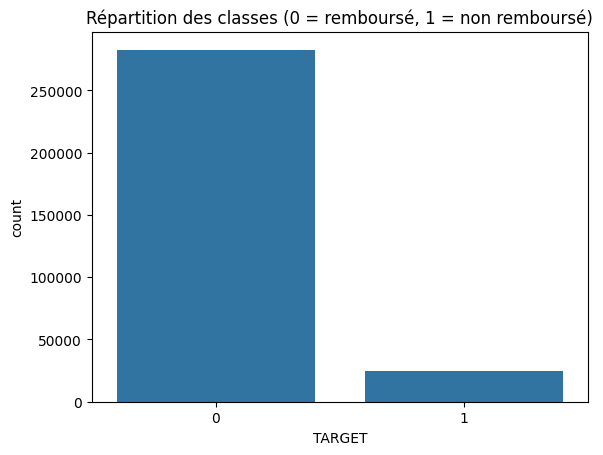

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=raw_data['application_train'], x='TARGET')
plt.title("R√©partition des classes (0 = rembours√©, 1 = non rembours√©)")
plt.show()

print(raw_data['application_train']['TARGET'].value_counts(normalize=True))

Comme il est indiqu√© qu'on le peut dans l'intitul√© du projet, je vais fortement m'inspirer du Kaggle mis √† disposition pour l'analyse exploratoire et le feature engineering. Je vais ajouter mes propres commentaires et autres visualisations suppl√©mentaires que je trouve pertinentes pour r√©pondre √† la probl√©matique m√©tier et comprendre les donn√©es. De plus, avant de me servir de ces notebooks Kaggle, j'ai moi m√™me analys√© chaque df et chaque colonne pour comprendre exactement de quoi il retourne. Je vais ensuite cr√©er mes propres mod√®les de machine learning, optimiser les hyperparam√®tres √† ma fa√ßon et choisir les m√©triques d'√©valuation que je trouve les plus pertinentes.

In [18]:
raw_data['application_train']['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

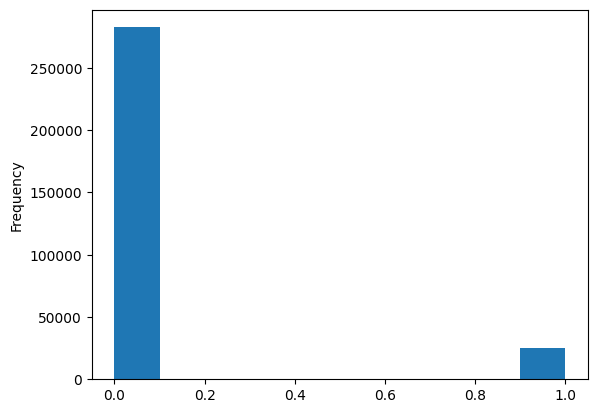

In [19]:
raw_data['application_train']['TARGET'].astype(int).plot.hist();

In [20]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [21]:
missing_values_table(raw_data['application_train'])

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_MODE                   214865               69.9
COMMONAREA_AVG                    214865               69.9
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_MEDI          213514               69.4
...                                  ...                ...
EXT_SOURCE_2                         660                0.2
AMT_GOODS_PRICE                      278                0.1
AMT_ANNUITY                           12                0.0
CNT_FAM_MEMBERS                        2                0.0
DAYS_LAST_PHONE_CHANGE                 1                0.0

[67 rows x 2 columns]

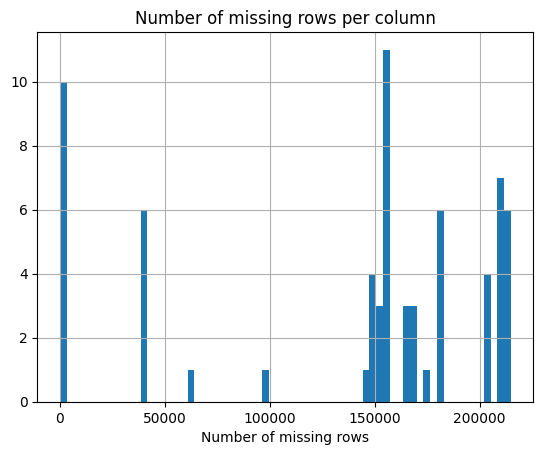

In [22]:
#We now have to deal with columns that contains null values
missing = raw_data['application_train'].isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

#Lets visualize the number of null values in all the columns
missing.hist(bins=len(missing))
plt.title('Number of missing rows per column')
plt.xlabel('Number of missing rows')
plt.show()

In [23]:
# Number of unique classes in each object column
raw_data['application_train'].select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [24]:
# Number of each type of column
raw_data['application_train'].dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [25]:
# Sauvegarde de la variable cible avant alignement
etiquettes_cible = raw_data['application_train']['TARGET']

# Alignement des colonnes entre les deux datasets (on garde uniquement les colonnes communes)
application_train, application_test = raw_data['application_train'].align(raw_data['application_test'], join='inner', axis=1)

# R√©int√©gration de la variable cible dans le jeu d'entra√Ænement
application_train['TARGET'] = etiquettes_cible

# Affichage des dimensions finales
print("Shape du jeu d'entra√Ænement :", application_train.shape)
print("Shape du jeu de test :", application_test.shape)

Shape du jeu d'entra√Ænement : (307511, 122)
Shape du jeu de test : (48744, 121)


In [26]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [27]:
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

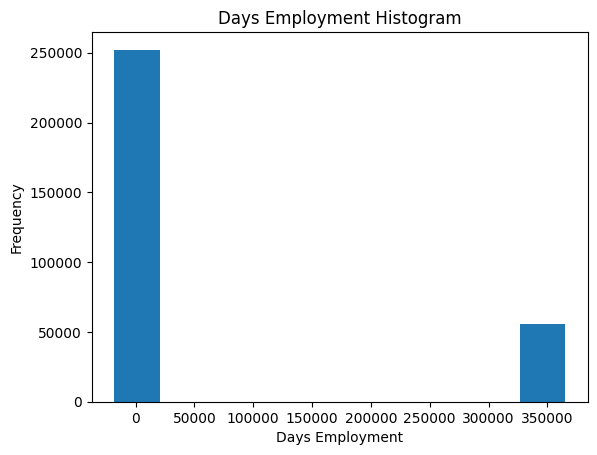

In [28]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [29]:
# S√©paration entre les valeurs normales et les valeurs anormales de la variable DAYS_EMPLOYED
valeurs_anormales = application_train[application_train['DAYS_EMPLOYED'] == 365243]
valeurs_normales = application_train[application_train['DAYS_EMPLOYED'] != 365243]

# Affichage du taux de d√©faut pour les deux groupes
print("Les clients sans anomalie de dur√©e d'emploi ont un taux de d√©faut de : %0.2f%%" %
      (100 * valeurs_normales['TARGET'].mean()))
print("Les clients avec anomalie (365243 jours) ont un taux de d√©faut de : %0.2f%%" %
      (100 * valeurs_anormales['TARGET'].mean()))
print("Il y a %d lignes avec une valeur anormale (365243 jours) dans DAYS_EMPLOYED." % len(valeurs_anormales))

Les clients sans anomalie de dur√©e d'emploi ont un taux de d√©faut de : 8.66%
Les clients avec anomalie (365243 jours) ont un taux de d√©faut de : 5.40%
Il y a 55374 lignes avec une valeur anormale (365243 jours) dans DAYS_EMPLOYED.


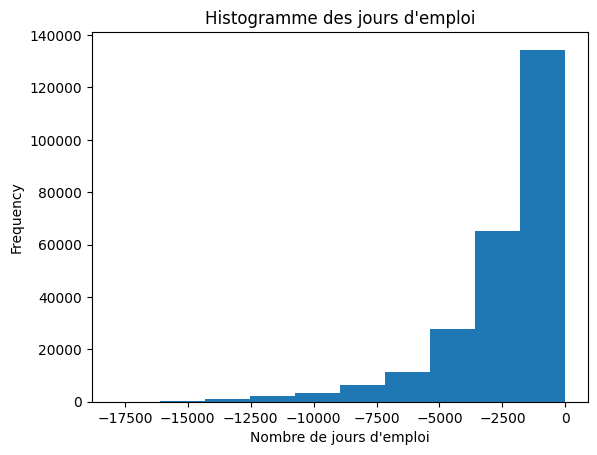

In [30]:
import numpy as np

# Cr√©ation d'une colonne indiquant si la valeur de DAYS_EMPLOYED est anormale (365243 jours)
application_train['DAYS_EMPLOYED_ANOM'] = application_train['DAYS_EMPLOYED'] == 365243

# Remplacement des valeurs anormales par NaN
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# Affichage d'un histogramme des jours d'emploi (hors valeurs aberrantes)
application_train['DAYS_EMPLOYED'].plot.hist(title='Histogramme des jours d\'emploi')
plt.xlabel('Nombre de jours d\'emploi')
plt.show()

In [31]:
# Cr√©ation d'une colonne pour indiquer les valeurs anormales dans le test set
application_test['DAYS_EMPLOYED_ANOM'] = application_test['DAYS_EMPLOYED'] == 365243

# Remplacement des valeurs anormales par NaN
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# Affichage du nombre d'anomalies d√©tect√©es
print("Il y a %d anomalies (valeurs √† 365243 jours) dans les donn√©es de test sur un total de %d entr√©es." %
      (application_test['DAYS_EMPLOYED_ANOM'].sum(), len(application_test)))

Il y a 9274 anomalies (valeurs √† 365243 jours) dans les donn√©es de test sur un total de 48744 entr√©es.


/tmp/ipython-input-4107985150.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


In [32]:
# Transformation de la variable DAYS_BIRTH en nombre de jours positifs (absolu)
application_train['DAYS_BIRTH'] = application_train['DAYS_BIRTH'].abs()

# Calcul de la corr√©lation entre l'√¢ge (en jours) et le d√©faut de cr√©dit
correlation = application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

# Affichage du r√©sultat
print("Corr√©lation entre l'√¢ge du client (en jours) et la variable cible TARGET :", round(correlation, 3))

Corr√©lation entre l'√¢ge du client (en jours) et la variable cible TARGET : -0.078


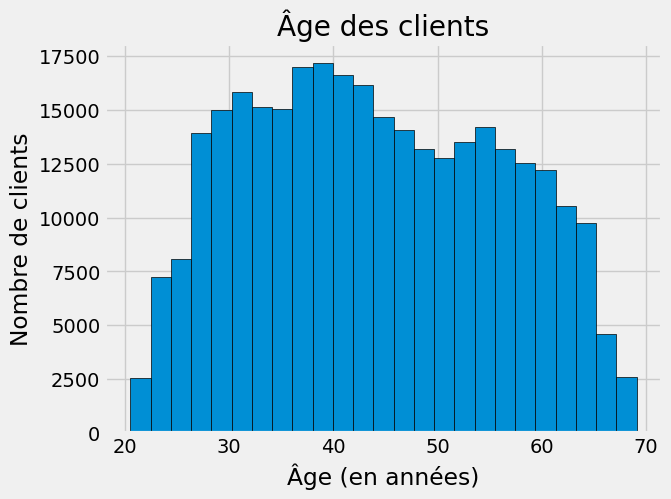

In [33]:
# D√©finit le style graphique
plt.style.use('fivethirtyeight')

# Trace l'histogramme de l'√¢ge des clients (en ann√©es)
plt.hist(application_train['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
plt.title("√Çge des clients")
plt.xlabel("√Çge (en ann√©es)")
plt.ylabel("Nombre de clients")
plt.show()

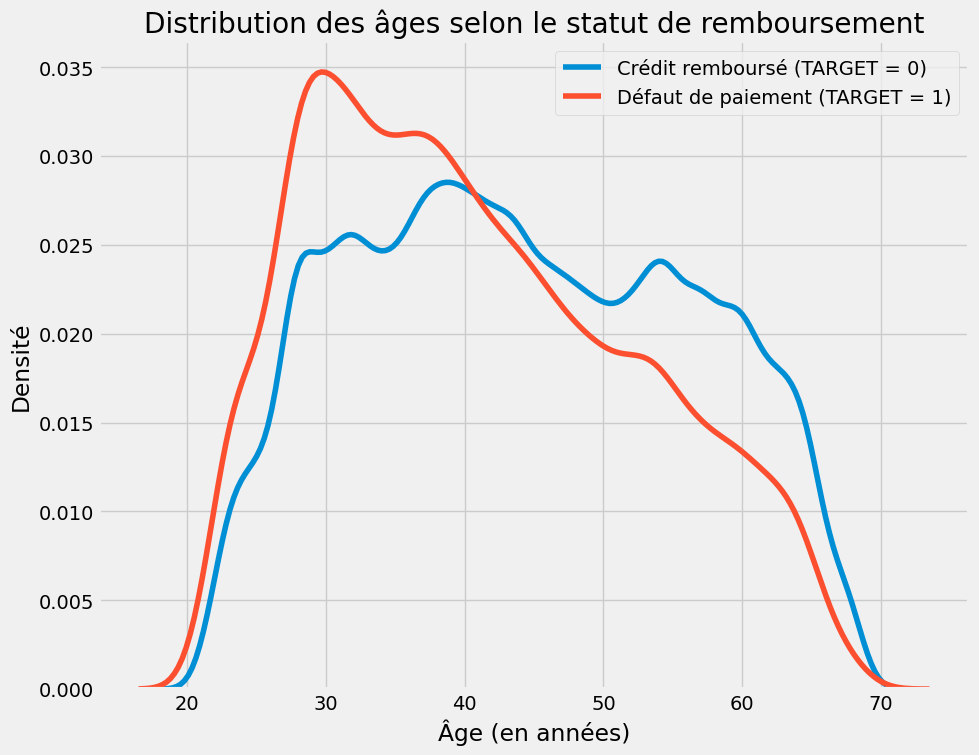

In [34]:
# On cr√©e une figure avec une taille personnalis√©e
plt.figure(figsize = (10, 8))

# Trac√© KDE des clients qui ont rembours√© leur pr√™t (TARGET = 0)
sns.kdeplot(
    application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365,
    label = 'Cr√©dit rembours√© (TARGET = 0)'
)

# Trac√© KDE des clients qui n'ont pas rembours√© leur pr√™t (TARGET = 1)
sns.kdeplot(
    application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365,
    label = 'D√©faut de paiement (TARGET = 1)'
)

# Titres et √©tiquettes
plt.xlabel('√Çge (en ann√©es)')
plt.ylabel('Densit√©')
plt.title('Distribution des √¢ges selon le statut de remboursement')
plt.legend()
plt.show()

Ce graphique KDE (Kernel Density Estimation) montre comment l‚Äô√¢ge des clients est corr√©l√© au risque de d√©faut de paiement.

In [35]:
# Extrait les colonnes d'√¢ge et de TARGET dans un nouveau DataFrame
age_data = application_train[['TARGET', 'DAYS_BIRTH']].copy()

# Converti l'√¢ge en ann√©es (valeurs absolues car les jours sont n√©gatifs)
age_data['AGE_EN_ANNEES'] = abs(age_data['DAYS_BIRTH']) / 365

# D√©coupe l'√¢ge en tranches r√©guli√®res entre 20 et 70 ans (10 intervalles)
age_data['TRANCHE_AGE'] = pd.cut(age_data['AGE_EN_ANNEES'], bins=np.linspace(20, 70, num=11))

# Affiche les 10 premi√®res lignes pour v√©rification
age_data.head(10)

TARGET  DAYS_BIRTH  AGE_EN_ANNEES   TRANCHE_AGE
0       1        9461      25.920548  (25.0, 30.0]
1       0       16765      45.931507  (45.0, 50.0]
2       0       19046      52.180822  (50.0, 55.0]
3       0       19005      52.068493  (50.0, 55.0]
4       0       19932      54.608219  (50.0, 55.0]
5       0       16941      46.413699  (45.0, 50.0]
6       0       13778      37.747945  (35.0, 40.0]
7       0       18850      51.643836  (50.0, 55.0]
8       0       20099      55.065753  (55.0, 60.0]
9       0       14469      39.641096  (35.0, 40.0]

/tmp/ipython-input-3687434046.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupes_age = age_data.groupby('TRANCHE_AGE').mean(numeric_only=True)


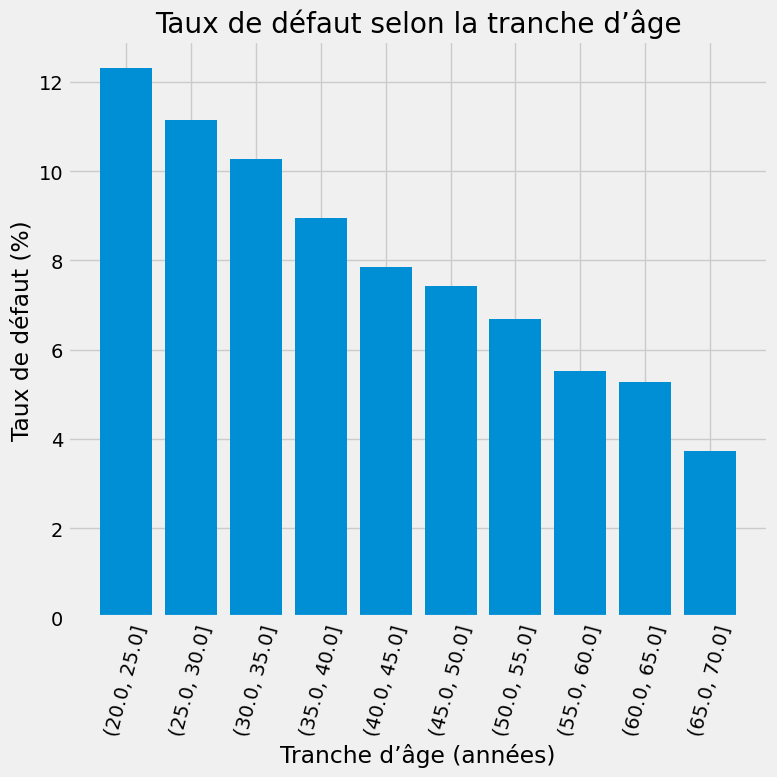

In [36]:
# Calcul du taux de d√©faut moyen pour chaque tranche d'√¢ge
groupes_age = age_data.groupby('TRANCHE_AGE').mean(numeric_only=True)

# Cr√©ation de la figure
plt.figure(figsize=(8, 8))

# Tracer un graphique en barres des tranches d'√¢ge vs. taux de d√©faut (%)
plt.bar(groupes_age.index.astype(str), 100 * groupes_age['TARGET'])

# Ajout des labels et du titre
plt.xticks(rotation=75)
plt.xlabel('Tranche d‚Äô√¢ge (ann√©es)')
plt.ylabel('Taux de d√©faut (%)')
plt.title('Taux de d√©faut selon la tranche d‚Äô√¢ge')

# Affichage du graphique
plt.tight_layout()
plt.show()

Comme l'a dit la personne sur Kaggle, on observe une tendance nette : les clients les plus jeunes ont un taux de d√©faut plus √©lev√©. Le taux de non-remboursement d√©passe les 10‚ÄØ% pour les trois tranches d‚Äô√¢ge les plus jeunes, alors qu‚Äôil descend sous les 5‚ÄØ% pour les tranches les plus √¢g√©es.

Cette information peut √™tre utile pour la banque : plut√¥t que d‚Äôexclure les jeunes emprunteurs, il serait judicieux de mettre en place un accompagnement renforc√© pour ces profils (ex. : conseils en gestion budg√©taire, rappel d‚Äô√©ch√©ances, etc.).

Cela permettrait de limiter les risques de d√©faut, sans discrimination, en agissant de mani√®re proactive.

In [37]:
# Pour afficher toute la largeur des colonnes sans troncature
pd.set_option('display.max_colwidth', None)

# Affichage des premi√®res lignes pour v√©rifier la structure
print(raw_data['HomeCredit_columns_description'].head())

# Filtrage des lignes contenant "EXT_SOURCE"
ext_source_desc = raw_data['HomeCredit_columns_description'][
    raw_data['HomeCredit_columns_description']['Row'].str.contains("EXT_SOURCE", na=False)
]

# Affichage avec description compl√®te
print("\nDescriptions compl√®tes des colonnes EXT_SOURCE :")
print(ext_source_desc[['Row', 'Description']])

   Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                                                                                                                                                                   Description  \
0                                                                                                                                                                     ID of loan in our sample   
1  Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)   
2              

Comme l'a indiqu√© l'utilisateur du projet Kaggle mis √† disposition, les trois variables EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3 sont celles qui pr√©sentent les corr√©lations n√©gatives les plus fortes avec la variable cible TARGET, c‚Äôest-√†-dire la probabilit√© qu‚Äôun client ne rembourse pas son cr√©dit.

D‚Äôapr√®s la documentation fournie (HomeCredit_columns_description.csv), ces variables repr√©sentent un score normalis√© provenant de sources de donn√©es externes ("Normalized score from external data source"). M√™me si la signification exacte de ces scores n‚Äôest pas d√©taill√©e, on peut supposer qu‚Äôil s‚Äôagit de notes de solvabilit√© calcul√©es √† partir de sources tierces, comme des agences de cr√©dit ou des historiques de paiement agr√©g√©s.

Autrement dit, ce sont probablement des indicateurs synth√©tiques (entre 0 et 1) de fiabilit√© financi√®re, utilis√©s pour √©valuer le risque de d√©faut de paiement d‚Äôun client selon des crit√®res externes √† la base de donn√©es principale.

Une valeur √©lev√©e de ces scores EXT_SOURCE semble associ√©e √† un faible risque de d√©faut, ce qui expliquerait leur corr√©lation n√©gative avec TARGET (0 = rembours√©, 1 = d√©faut de paiement).

In [38]:
# Extrait les variables EXT_SOURCE ainsi que l'√¢ge et la cible
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# Calcul de la matrice de corr√©lation entre ces variables
correlations_ext = ext_data.corr()

# Affiche la matrice de corr√©lation
print("Corr√©lations entre les variables EXT_SOURCE, l'√¢ge et la cible :\n")
print(correlations_ext)

Corr√©lations entre les variables EXT_SOURCE, l'√¢ge et la cible :

                TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000


Text(0.5, 1.0, 'Heatmap des corr√©lations entre EXT_SOURCE, √¢ge et cible')

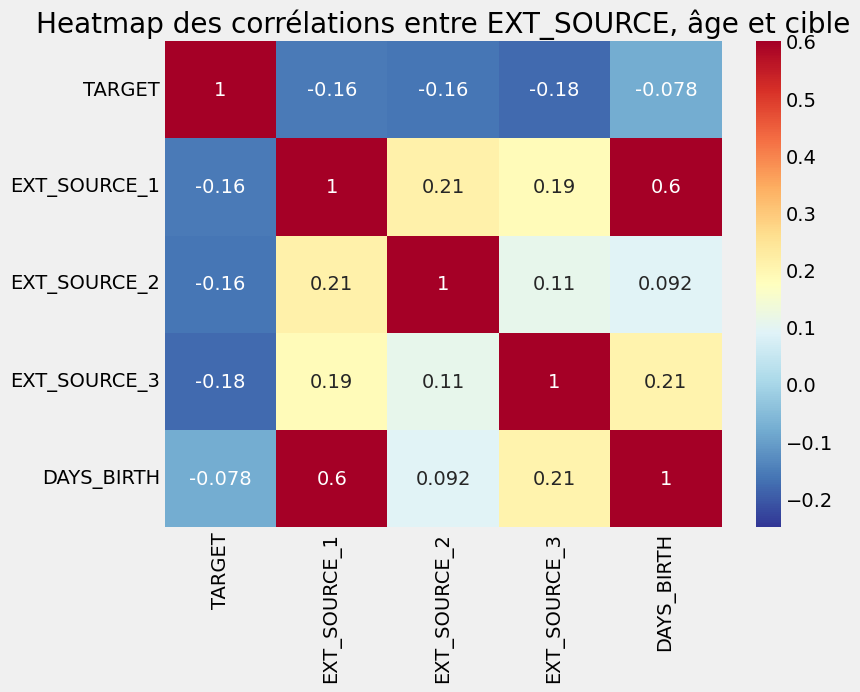

In [39]:
# Cr√©e une figure avec une taille personnalis√©e
plt.figure(figsize=(8, 6))

# Affiche une carte thermique des corr√©lations entre EXT_SOURCE, l'√¢ge et la cible
# - cmap : la palette de couleurs utilis√©e (du rouge au bleu)
# - vmin et vmax : les bornes des valeurs de corr√©lation √† afficher
# - annot = True : affiche les valeurs dans chaque case
sns.heatmap(correlations_ext, cmap=plt.cm.RdYlBu_r, vmin=-0.25, vmax=0.6, annot=True)

# Ajoute un titre au graphique
plt.title("Heatmap des corr√©lations entre EXT_SOURCE, √¢ge et cible")

Les trois variables EXT_SOURCE pr√©sentent toutes une corr√©lation n√©gative avec la variable cible TARGET. Cela signifie que plus la valeur d'une variable EXT_SOURCE est √©lev√©e, plus le client a de chances de rembourser son pr√™t. Autrement dit, un score externe √©lev√© est g√©n√©ralement un bon indicateur de fiabilit√©.

Gr√¢ce au travail de la personne du projet Kaggle, on observe √©galement que la variable DAYS_BIRTH est positivement corr√©l√©e avec EXT_SOURCE_1, ce qui peut sugg√©rer que l‚Äô√¢ge du client est l‚Äôun des √©l√©ments pris en compte dans le calcul de ce score externe.

Ensuite, nous allons examiner la distribution de chacune de ces variables EXT_SOURCE, en les colorant selon la valeur de la cible (TARGET). Cela nous permettra de visualiser plus concr√®tement l‚Äôinfluence de chaque score externe sur le risque de d√©faut de paiement.

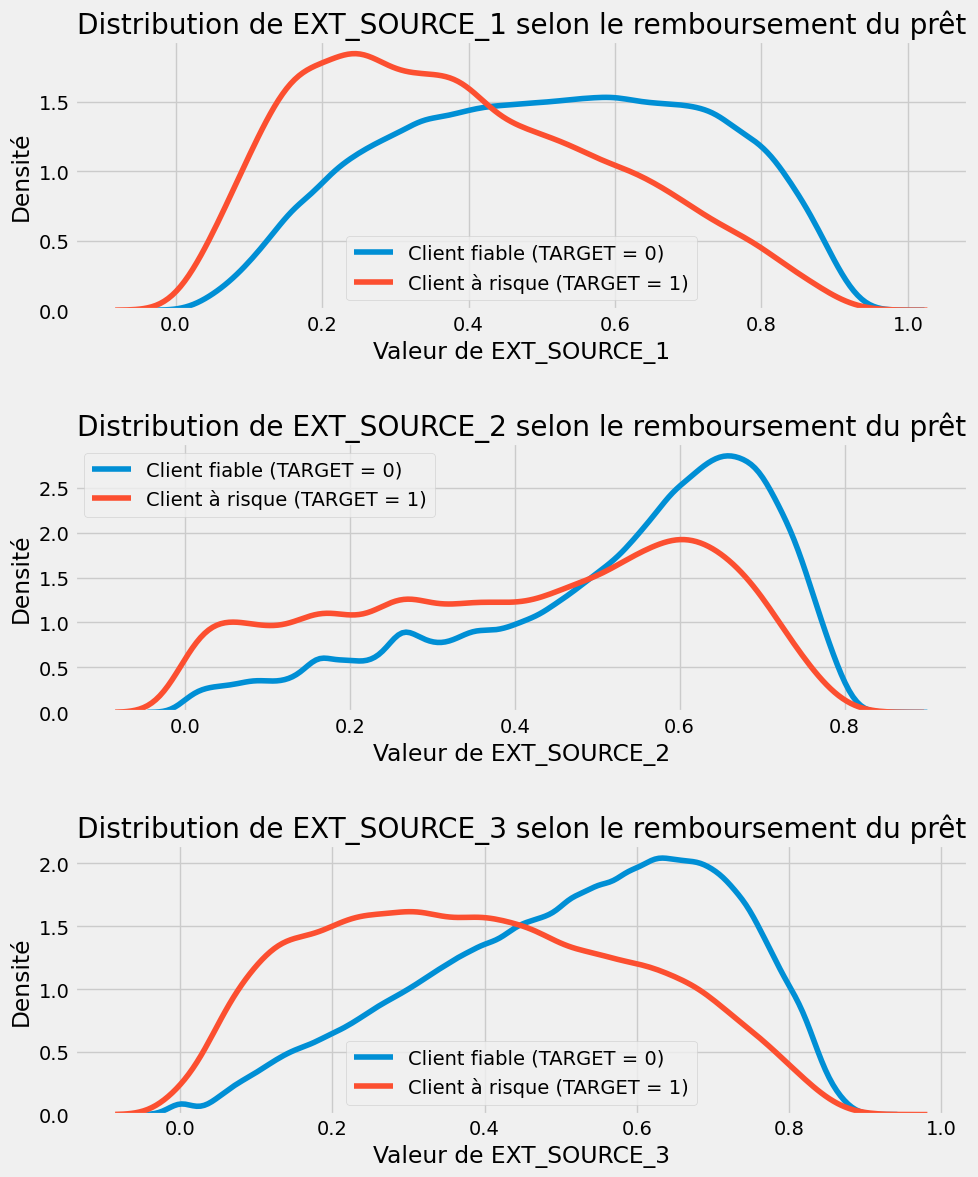

In [40]:
# Cr√©e une figure de taille verticale adapt√©e √† 3 graphiques
plt.figure(figsize=(10, 12))

# Boucle sur les 3 variables EXT_SOURCE
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # Cr√©e un sous-graphique (subplot) par EXT_SOURCE
    plt.subplot(3, 1, i + 1)

    # Trace la distribution des scores pour les clients qui ont rembours√© (TARGET = 0)
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label='Client fiable (TARGET = 0)')

    # Trace la distribution des scores pour les clients qui n'ont pas rembours√© (TARGET = 1)
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label='Client √† risque (TARGET = 1)')

    # Ajoute les titres et l√©gendes
    plt.title(f'Distribution de {source} selon le remboursement du pr√™t')
    plt.xlabel(f'Valeur de {source}')
    plt.ylabel('Densit√©')
    plt.legend()

# Ajustement automatique de l'espacement vertical entre les sous-graphes
plt.tight_layout(h_pad=2.5)

Parmi les trois variables EXT_SOURCE, c‚Äôest EXT_SOURCE_3 qui montre la plus grande diff√©rence de distribution entre les clients qui remboursent leur pr√™t et ceux qui ne le font pas. Cela sugg√®re qu‚Äôil existe une relation notable entre ce score et la probabilit√© de remboursement.

M√™me si la corr√©lation reste faible d‚Äôun point de vue statistique, ces variables contiennent tout de m√™me des informations utiles que les mod√®les de machine learning peuvent exploiter pour mieux pr√©dire le risque de d√©faut d‚Äôun client. Ce sont des signaux faibles, mais potentiellement pr√©cieux une fois combin√©s avec d'autres donn√©es.

Apr√®s avoir fait ma propre premi√®re analyse des df puis avoir repris le notebook Kaggle mis √† disposition pour la suite de l'analyse exploratoire et pr√©traitement des donn√©es, avoir ajout√© des visualisations suppl√©mentaires et commentaires, je vais maintenant proc√©der au feature engineering notamment √† l'aide d'un autre notebook Kaggle mis √† disposition en expliquant la d√©marche. Puis, il me restera √† cr√©er mes propres mod√®les de machine learning qui sont au coeur du projet et chercherai √† optimiser au mieux leurs hyperparam√®tres et choisirai les m√©triques d'√©valuation que j'estime les plus pertinentes.

In [41]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    """Contexte manager pour mesurer le temps d'ex√©cution"""
    t0 = time.time()
    yield
    print("{} - termin√© en {:.0f}s".format(title, time.time() - t0))

def safe_div(a, b, fill_value=0):
    """Division s√©curis√©e qui g√®re les divisions par z√©ro et les infinis"""
    result = np.divide(a, b, out=np.zeros_like(a, dtype=float), where=(b != 0))
    result = np.where(np.isinf(result), fill_value, result)
    result = np.where(np.isnan(result), fill_value, result)
    return result

def one_hot_encoder(df, nan_as_category=True):
    """Applique un encodage One-Hot aux variables cat√©gorielles"""
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def remove_constant_columns(df, threshold=0.98):
    """
    Supprime les colonnes avec une seule valeur unique ou trop peu de variance

    Param√®tres:
    - df: DataFrame
    - threshold: Si une valeur repr√©sente plus de ce % des donn√©es, supprime la colonne
    """
    cols_to_drop = []

    for col in df.columns:
        if col in ['SK_ID_CURR', 'TARGET']:
            continue

        # V√©rifie si une seule valeur unique
        if df[col].nunique(dropna=False) <= 1:
            cols_to_drop.append(col)
            continue

        # V√©rifie si une valeur domine (>98% des donn√©es)
        value_counts = df[col].value_counts(dropna=False, normalize=True)
        if len(value_counts) > 0 and value_counts.iloc[0] > threshold:
            cols_to_drop.append(col)

    if cols_to_drop:
        print(f"Suppression de {len(cols_to_drop)} colonnes constantes/quasi-constantes")
        df.drop(columns=cols_to_drop, inplace=True)

    return df

def application_train_preprocessing(num_rows=None, nan_as_category=False):
    """Pr√©processe application_train.csv avec features avanc√©es"""

    df = pd.read_csv(DATA_DIR / 'application_train.csv', nrows=num_rows)
    print("√âchantillons d'entra√Ænement: {}".format(len(df)))

    # Supprime les valeurs aberrantes
    df = df[df['CODE_GENDER'] != 'XNA']

    # Variables binaires
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # One-Hot encoding
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Gestion des valeurs aberrantes DAYS_EMPLOYED
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_EMPLOYED_ANOM'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)

    # ============== FEATURES DE BASE (SAFE) ==============

    # Ratios de revenus et cr√©dit
    df['INCOME_CREDIT_PERC'] = safe_div(df['AMT_INCOME_TOTAL'], df['AMT_CREDIT'])
    df['INCOME_PER_PERSON'] = safe_div(df['AMT_INCOME_TOTAL'], df['CNT_FAM_MEMBERS'])
    df['ANNUITY_INCOME_PERC'] = safe_div(df['AMT_ANNUITY'], df['AMT_INCOME_TOTAL'])
    df['PAYMENT_RATE'] = safe_div(df['AMT_ANNUITY'], df['AMT_CREDIT'])
    df['CREDIT_TO_ANNUITY_RATIO'] = safe_div(df['AMT_CREDIT'], df['AMT_ANNUITY'])
    df['CREDIT_TO_GOODS_RATIO'] = safe_div(df['AMT_CREDIT'], df['AMT_GOODS_PRICE'])

    # Ratios temporels (en valeur absolue)
    df['DAYS_EMPLOYED_PERC'] = safe_div(df['DAYS_EMPLOYED'], df['DAYS_BIRTH'])
    df['DAYS_EMPLOYED_RATIO'] = safe_div(df['DAYS_EMPLOYED'].abs(), df['DAYS_BIRTH'].abs())
    df['AGE_TO_CREDIT_RATIO'] = safe_div(df['DAYS_BIRTH'].abs(), df['AMT_CREDIT'])
    df['INCOME_PER_AGE'] = safe_div(df['AMT_INCOME_TOTAL'], df['DAYS_BIRTH'].abs() / 365)

    # ============== FEATURES EXTERNES (TR√àS IMPORTANTES) ==============

    # EXT_SOURCE features
    df['EXT_SOURCE_1'].fillna(df['EXT_SOURCE_1'].median(), inplace=True)
    df['EXT_SOURCE_2'].fillna(df['EXT_SOURCE_2'].median(), inplace=True)
    df['EXT_SOURCE_3'].fillna(df['EXT_SOURCE_3'].median(), inplace=True)

    df['EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['EXT_SOURCES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['EXT_SOURCES_MIN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1)
    df['EXT_SOURCES_MAX'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1)
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df['EXT_SOURCE_1'] * 2 + df['EXT_SOURCE_2'] * 3 + df['EXT_SOURCE_3'] * 4
    df['EXT_SOURCES_RANGE'] = df['EXT_SOURCES_MAX'] - df['EXT_SOURCES_MIN']

    # Interactions EXT_SOURCE avec autres variables
    df['EXT_SOURCE_1_X_CREDIT'] = df['EXT_SOURCE_1'] * df['AMT_CREDIT']
    df['EXT_SOURCE_2_X_CREDIT'] = df['EXT_SOURCE_2'] * df['AMT_CREDIT']
    df['EXT_SOURCE_3_X_CREDIT'] = df['EXT_SOURCE_3'] * df['AMT_CREDIT']

    # ============== FEATURES DE DOCUMENTS ==============

    doc_flags = [col for col in df.columns if col.startswith('FLAG_DOCUMENT_')]
    df['DOCUMENT_COUNT'] = df[doc_flags].sum(axis=1)

    # ============== FEATURES DE CONTACT ==============

    contact_flags = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
                     'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']
    df['CONTACT_INFO_COUNT'] = df[contact_flags].sum(axis=1)

    # ============== FEATURES DE R√âGION ==============

    region_cols = [col for col in df.columns if 'REGION' in col and 'RATING' in col]
    if region_cols:
        df['REGION_RATING_MEAN'] = df[region_cols].mean(axis=1)

    # ============== FEATURES D'ENQU√äTE ==============

    enquiry_cols = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
                    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

    for col in enquiry_cols:
        if col in df.columns:
            df[col].fillna(0, inplace=True)

    df['CREDIT_ENQUIRIES_TOTAL'] = df[enquiry_cols].sum(axis=1)
    df['CREDIT_ENQUIRIES_RECENT'] = df[['AMT_REQ_CREDIT_BUREAU_HOUR',
                                         'AMT_REQ_CREDIT_BUREAU_DAY']].sum(axis=1)

    # ============== SCORE DE STABILIT√â ==============

    df['FINANCIAL_STABILITY_SCORE'] = (
        safe_div(df['AMT_INCOME_TOTAL'], df['AMT_CREDIT']) *
        safe_div(df['DAYS_EMPLOYED'].abs(), df['DAYS_BIRTH'].abs())
    ).clip(0, 10)

    # ============== FEATURES D√âMOGRAPHIQUES ==============

    df['AGE_YEARS'] = (df['DAYS_BIRTH'].abs() / 365).astype(int)
    df['EMPLOYMENT_YEARS'] = (df['DAYS_EMPLOYED'].abs() / 365)
    df['CAR_AGE_RATIO'] = safe_div(df['OWN_CAR_AGE'], df['AGE_YEARS'])

    # ============== NETTOYAGE FINAL ==============

    # Remplace les infinis restants
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Supprime les colonnes constantes
    df = remove_constant_columns(df)

    gc.collect()
    return df

def bureau_and_balance(num_rows=None, nan_as_category=True):
    """Pr√©processe bureau.csv et bureau_balance.csv avec features avanc√©es"""

    bureau = pd.read_csv(DATA_DIR / 'bureau.csv', nrows=num_rows)
    bb = pd.read_csv(DATA_DIR / 'bureau_balance.csv', nrows=num_rows)

    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # ============== BUREAU BALANCE AGGREGATIONS ==============

    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size', 'mean', 'std']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']

    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)

    del bb, bb_agg
    gc.collect()

    # ============== FEATURES SUPPL√âMENTAIRES BUREAU ==============

    # Binary features
    bureau['CREDIT_ENDDATE_BINARY'] = (bureau['DAYS_CREDIT_ENDDATE'] > 0).astype(int)
    bureau['DEBT_CREDIT_RATIO'] = safe_div(bureau['AMT_CREDIT_SUM_DEBT'], bureau['AMT_CREDIT_SUM'])
    bureau['OVERDUE_RATIO'] = safe_div(bureau['AMT_CREDIT_SUM_OVERDUE'], bureau['AMT_CREDIT_SUM'])
    bureau['CREDIT_UTILIZATION'] = safe_div(bureau['AMT_CREDIT_SUM_DEBT'], bureau['AMT_CREDIT_SUM_LIMIT'])

    # ============== AGR√âGATIONS NUM√âRIQUES ==============

    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var', 'std'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean', 'std'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum', 'std'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum', 'std'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum', 'max'],
        'AMT_ANNUITY': ['max', 'mean', 'std'],
        'CNT_CREDIT_PROLONG': ['sum', 'mean'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'DEBT_CREDIT_RATIO': ['mean', 'max'],
        'OVERDUE_RATIO': ['mean', 'max'],
        'CREDIT_UTILIZATION': ['mean', 'max']
    }

    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Nombre de cr√©dits au bureau
    bureau_agg['BURO_COUNT'] = bureau.groupby('SK_ID_CURR').size()

    # ============== CR√âDITS ACTIFS ==============

    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    if len(active) > 0:
        active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
        active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
        bureau_agg['ACTIVE_COUNT'] = active.groupby('SK_ID_CURR').size()
        del active_agg

    # ============== CR√âDITS FERM√âS ==============

    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    if len(closed) > 0:
        closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
        closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
        bureau_agg['CLOSED_COUNT'] = closed.groupby('SK_ID_CURR').size()
        del closed_agg

    # ============== RATIO ACTIFS/FERM√âS ==============

    bureau_agg['ACTIVE_TO_CLOSED_RATIO'] = safe_div(
        bureau_agg.get('ACTIVE_COUNT', 0),
        bureau_agg.get('CLOSED_COUNT', 0)
    )

    del active, closed, bureau
    gc.collect()

    # Nettoyage
    bureau_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    bureau_agg = remove_constant_columns(bureau_agg)

    return bureau_agg

def previous_applications(num_rows=None, nan_as_category=True):
    """Pr√©processe previous_application.csv avec features avanc√©es"""

    prev = pd.read_csv(DATA_DIR / 'previous_application.csv', nrows=num_rows, on_bad_lines='skip')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    # Gestion des valeurs aberrantes
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

    # ============== FEATURES AVANC√âES ==============

    prev['APP_CREDIT_PERC'] = safe_div(prev['AMT_APPLICATION'], prev['AMT_CREDIT'])
    prev['CREDIT_TO_ANNUITY_RATIO'] = safe_div(prev['AMT_CREDIT'], prev['AMT_ANNUITY'])
    prev['DOWN_PAYMENT_PERC'] = safe_div(prev['AMT_DOWN_PAYMENT'], prev['AMT_APPLICATION'])
    prev['CREDIT_TO_GOODS_RATIO'] = safe_div(prev['AMT_CREDIT'], prev['AMT_GOODS_PRICE'])
    prev['INTEREST_RATE'] = safe_div(prev['AMT_ANNUITY'] * prev['CNT_PAYMENT'], prev['AMT_CREDIT']) - 1

    # Features temporelles
    prev['DAYS_DECISION_TO_BIRTH'] = prev['DAYS_DECISION'] - prev['DAYS_BIRTH'] if 'DAYS_BIRTH' in prev.columns else 0

    # ============== AGR√âGATIONS ==============

    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean', 'std'],
        'AMT_APPLICATION': ['min', 'max', 'mean', 'std'],
        'AMT_CREDIT': ['min', 'max', 'mean', 'sum', 'std'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'std'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean', 'std'],
        'CNT_PAYMENT': ['mean', 'sum', 'max'],
        'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
        'DOWN_PAYMENT_PERC': ['mean', 'max'],
        'CREDIT_TO_GOODS_RATIO': ['mean', 'max'],
        'INTEREST_RATE': ['mean', 'max', 'min']
    }

    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    prev_agg['PREV_COUNT'] = prev.groupby('SK_ID_CURR').size()

    # ============== DEMANDES APPROUV√âES ==============

    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    if len(approved) > 0:
        approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
        approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
        prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
        prev_agg['APPROVED_COUNT'] = approved.groupby('SK_ID_CURR').size()
        del approved_agg

    # ============== DEMANDES REFUS√âES ==============

    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    if len(refused) > 0:
        refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
        refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
        prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
        prev_agg['REFUSED_COUNT'] = refused.groupby('SK_ID_CURR').size()
        del refused_agg

    # ============== TAUX D'APPROBATION ==============

    prev_agg['APPROVAL_RATE'] = safe_div(
        prev_agg.get('APPROVED_COUNT', 0),
        prev_agg.get('PREV_COUNT', 1)
    )

    del refused, approved, prev
    gc.collect()

    prev_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    prev_agg = remove_constant_columns(prev_agg)

    return prev_agg

def pos_cash(num_rows=None, nan_as_category=True):
    """Pr√©processe POS_CASH_balance.csv avec features avanc√©es"""

    pos = pd.read_csv(DATA_DIR / 'POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)

    # ============== FEATURES SUPPL√âMENTAIRES ==============

    pos['IS_DPD'] = (pos['SK_DPD'] > 0).astype(int)
    pos['IS_DPD_DEF'] = (pos['SK_DPD_DEF'] > 0).astype(int)

    # ============== AGR√âGATIONS ==============

    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size', 'min', 'std'],
        'SK_DPD': ['max', 'mean', 'sum', 'std'],
        'SK_DPD_DEF': ['max', 'mean', 'sum'],
        'IS_DPD': ['mean', 'sum'],
        'IS_DPD_DEF': ['mean', 'sum']
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

    # Taux de retard
    pos_agg['POS_DPD_RATE'] = safe_div(pos_agg['POS_IS_DPD_SUM'], pos_agg['POS_COUNT'])

    del pos
    gc.collect()

    pos_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    pos_agg = remove_constant_columns(pos_agg)

    return pos_agg

def installments_payments(num_rows=None, nan_as_category=True):
    """Pr√©processe installments_payments.csv avec features avanc√©es"""

    ins = pd.read_csv(DATA_DIR / 'installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)

    # ============== FEATURES AVANC√âES ==============

    ins['PAYMENT_PERC'] = safe_div(ins['AMT_PAYMENT'], ins['AMT_INSTALMENT'])
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    ins['PAYMENT_RATIO'] = safe_div(ins['AMT_PAYMENT'], ins['AMT_INSTALMENT'])

    # Jours de retard
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    # Binary features
    ins['IS_LATE'] = (ins['DPD'] > 0).astype(int)
    ins['IS_EARLY'] = (ins['DBD'] > 0).astype(int)
    ins['PAID_OVER'] = (ins['AMT_PAYMENT'] > ins['AMT_INSTALMENT']).astype(int)
    ins['PAID_UNDER'] = (ins['AMT_PAYMENT'] < ins['AMT_INSTALMENT']).astype(int)

    # ============== AGR√âGATIONS ==============

    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique', 'max'],
        'DPD': ['max', 'mean', 'sum', 'std'],
        'DBD': ['max', 'mean', 'sum', 'std'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var', 'std'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var', 'std'],
        'PAYMENT_RATIO': ['mean', 'std'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum', 'std'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum', 'std'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum'],
        'IS_LATE': ['mean', 'sum'],
        'IS_EARLY': ['mean', 'sum'],
        'PAID_OVER': ['mean', 'sum'],
        'PAID_UNDER': ['mean', 'sum']
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']

    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    # Taux de retard
    ins_agg['INSTAL_LATE_RATE'] = safe_div(ins_agg['INSTAL_IS_LATE_SUM'], ins_agg['INSTAL_COUNT'])
    ins_agg['INSTAL_PAYMENT_SUCCESS_RATE'] = 1 - safe_div(ins_agg['INSTAL_PAID_UNDER_SUM'], ins_agg['INSTAL_COUNT'])

    del ins
    gc.collect()

    ins_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    ins_agg = remove_constant_columns(ins_agg)

    return ins_agg

def credit_card_balance(num_rows=None, nan_as_category=True):
    """Pr√©processe credit_card_balance.csv avec features avanc√©es"""

    cc = pd.read_csv(DATA_DIR / 'credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)

    # ============== FEATURES AVANC√âES ==============

    cc['BALANCE_LIMIT_RATIO'] = safe_div(cc['AMT_BALANCE'], cc['AMT_CREDIT_LIMIT_ACTUAL'])
    cc['MIN_PAYMENT_RATIO'] = safe_div(cc['AMT_PAYMENT_CURRENT'], cc['AMT_INST_MIN_REGULARITY'])
    cc['PAYMENT_DIV_MIN'] = safe_div(cc['AMT_PAYMENT_CURRENT'], cc['AMT_INST_MIN_REGULARITY'])
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    cc['DRAWING_LIMIT_RATIO'] = safe_div(cc['AMT_DRAWINGS_ATM_CURRENT'] + cc['AMT_DRAWINGS_CURRENT'] +
                                         cc['AMT_DRAWINGS_POS_CURRENT'], cc['AMT_CREDIT_LIMIT_ACTUAL'])

    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)

    # ============== AGR√âGATIONS ==============

    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var', 'std'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    # Taux de retard
    if 'CC_LATE_PAYMENT_SUM' in cc_agg.columns:
        cc_agg['CC_LATE_PAYMENT_RATE'] = safe_div(cc_agg['CC_LATE_PAYMENT_SUM'], cc_agg['CC_COUNT'])

    del cc
    gc.collect()

    cc_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    cc_agg = remove_constant_columns(cc_agg)

    return cc_agg

def prepare_data_for_modeling(df):
    """Pr√©pare les donn√©es pour la mod√©lisation"""
    feats = [f for f in df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
    X = df[feats]
    y = df['TARGET']
    return X, y, feats

def display_importances(feature_importance_df_):
    """Affiche un graphique des features les plus importantes"""
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Importance des Features (moyenne sur les folds)')
    plt.tight_layout()
    plt.savefig('feature_importances.png')
    plt.show()

def add_cross_dataset_features(df):
    """
    Ajoute des features cross-dataset (interactions entre diff√©rentes sources)
    √Ä appeler APR√àS avoir joint tous les datasets
    """
    print("\nCr√©ation de features cross-dataset...")

    # Ratios Bureau / Application
    if 'BURO_AMT_CREDIT_SUM_MEAN' in df.columns:
        df['BURO_TO_APP_CREDIT_RATIO'] = safe_div(df['BURO_AMT_CREDIT_SUM_MEAN'], df['AMT_CREDIT'])
        df['BURO_TO_APP_DEBT_RATIO'] = safe_div(df['BURO_AMT_CREDIT_SUM_DEBT_MEAN'], df['AMT_CREDIT'])

    # Ratios Previous / Application
    if 'PREV_AMT_CREDIT_MEAN' in df.columns:
        df['PREV_TO_APP_CREDIT_RATIO'] = safe_div(df['PREV_AMT_CREDIT_MEAN'], df['AMT_CREDIT'])
        df['PREV_TO_APP_ANNUITY_RATIO'] = safe_div(df['PREV_AMT_ANNUITY_MEAN'], df['AMT_ANNUITY'])

    # Score composite de risque
    risk_score = 0
    if 'INSTAL_LATE_RATE' in df.columns:
        risk_score += df['INSTAL_LATE_RATE'].fillna(0) * 0.3
    if 'POS_DPD_RATE' in df.columns:
        risk_score += df['POS_DPD_RATE'].fillna(0) * 0.3
    if 'BURO_CREDIT_DAY_OVERDUE_MEAN' in df.columns:
        risk_score += (df['BURO_CREDIT_DAY_OVERDUE_MEAN'].fillna(0) / 365) * 0.4

    df['COMPOSITE_RISK_SCORE'] = risk_score.clip(0, 1)

    # Score de comportement de paiement
    if 'INSTAL_PAYMENT_SUCCESS_RATE' in df.columns and 'CC_LATE_PAYMENT_RATE' in df.columns:
        df['PAYMENT_BEHAVIOR_SCORE'] = (
            df['INSTAL_PAYMENT_SUCCESS_RATE'].fillna(0.5) * 0.5 +
            (1 - df['CC_LATE_PAYMENT_RATE'].fillna(0.5)) * 0.5
        )

    # Exp√©rience cr√©dit totale
    experience_score = 0
    if 'BURO_COUNT' in df.columns:
        experience_score += df['BURO_COUNT'].fillna(0) / 10
    if 'PREV_COUNT' in df.columns:
        experience_score += df['PREV_COUNT'].fillna(0) / 10

    df['CREDIT_EXPERIENCE_SCORE'] = experience_score.clip(0, 2)

    print(f"Features cross-dataset cr√©√©es : {['BURO_TO_APP_CREDIT_RATIO', 'COMPOSITE_RISK_SCORE', 'PAYMENT_BEHAVIOR_SCORE', 'CREDIT_EXPERIENCE_SCORE']}")

    return df

def main(debug=False):
    """Fonction principale qui orchestre tout le preprocessing"""

    num_rows = 10000 if debug else None

    print("=" * 60)
    print("D√âBUT DU PREPROCESSING OPTIMIS√â - HOME CREDIT")
    print("=" * 60)

    # Application train
    df = application_train_preprocessing(num_rows)
    print(f"\n‚úì Dataset principal: {df.shape}")

    # Bureau
    with timer("Traitement de bureau et bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print(f"‚úì Bureau: {bureau.shape}")
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()

    # Previous applications
    with timer("Traitement des demandes pr√©c√©dentes"):
        prev = previous_applications(num_rows)
        print(f"‚úì Previous applications: {prev.shape}")
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()

    # POS-CASH
    with timer("Traitement des soldes POS-CASH"):
        pos = pos_cash(num_rows)
        print(f"‚úì POS-CASH: {pos.shape}")
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()

    # Installments
    with timer("Traitement des paiements d'√©ch√©ances"):
        ins = installments_payments(num_rows)
        print(f"‚úì Installments: {ins.shape}")
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()

    # Credit card
    with timer("Traitement des cartes de cr√©dit"):
        cc = credit_card_balance(num_rows)
        print(f"‚úì Credit cards: {cc.shape}")
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    # Features cross-dataset
    with timer("Cr√©ation des features cross-dataset"):
        df = add_cross_dataset_features(df)

    # Nettoyage final
    print("\nNettoyage final...")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = remove_constant_columns(df, threshold=0.98)

    # Statistiques finales
    print("\n" + "=" * 60)
    print("PREPROCESSING TERMIN√â AVEC SUCC√àS")
    print("=" * 60)
    print(f"‚úì Dataset final: {df.shape}")
    print(f"‚úì Nombre de features: {df.shape[1] - 2}")  # -2 pour TARGET et SK_ID_CURR
    print(f"‚úì Valeurs manquantes: {df.isnull().sum().sum():,}")
    print(f"‚úì Valeurs infinies: {np.isinf(df.select_dtypes(include=[np.number])).sum().sum()}")
    print(f"\n‚úì Distribution de la target:")
    print(df['TARGET'].value_counts())
    print(f"\n‚úì Taux de d√©faut: {df['TARGET'].mean():.2%}")

    return df

# Exemple d'utilisation
if __name__ == "__main__":
    # Configuration du chemin des donn√©es
    from pathlib import Path
    DATA_DIR = Path('./data')  # Modifie selon ton chemin

    # Lancement du preprocessing
    df = main(debug=False)

    # Pr√©paration pour la mod√©lisation
    X, y, feature_names = prepare_data_for_modeling(df)

    print(f"\n{'=' * 60}")
    print("DONN√âES PR√äTES POUR LA MOD√âLISATION")
    print(f"{'=' * 60}")
    print(f"‚úì Features (X): {X.shape}")
    print(f"‚úì Target (y): {y.shape}")
    print(f"‚úì Nombre total de features: {len(feature_names)}")
    print(f"\n‚úì Exemples de features cr√©√©es:")
    feature_examples = [f for f in feature_names if any(keyword in f for keyword in
                       ['EXT_SOURCE', 'RISK', 'RATIO', 'CROSS', 'BEHAVIOR'])][:10]
    for feat in feature_examples:
        print(f"  - {feat}")

    # Sauvegarde optionnelle
    # df.to_csv('processed_data.csv', index=False)
    # print("\n‚úì Donn√©es sauvegard√©es dans 'processed_data.csv'")

D√âBUT DU PREPROCESSING OPTIMIS√â - HOME CREDIT
√âchantillons d'entra√Ænement: 307511
Suppression de 103 colonnes constantes/quasi-constantes

‚úì Dataset principal: (307507, 169)
Suppression de 27 colonnes constantes/quasi-constantes
‚úì Bureau: (305811, 147)
Traitement de bureau et bureau_balance - termin√© en 31s


/tmp/ipython-input-3760789891.py:328: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prev_agg['PREV_COUNT'] = prev.groupby('SK_ID_CURR').size()


Suppression de 73 colonnes constantes/quasi-constantes
‚úì Previous applications: (338857, 228)
Traitement des demandes pr√©c√©dentes - termin√© en 41s
Suppression de 7 colonnes constantes/quasi-constantes
‚úì POS-CASH: (337252, 21)
Traitement des soldes POS-CASH - termin√© en 20s
‚úì Installments: (339587, 45)
Traitement des paiements d'√©ch√©ances - termin√© en 36s
Suppression de 38 colonnes constantes/quasi-constantes
‚úì Credit cards: (103558, 162)
Traitement des cartes de cr√©dit - termin√© en 28s

Cr√©ation de features cross-dataset...
Features cross-dataset cr√©√©es : ['BURO_TO_APP_CREDIT_RATIO', 'COMPOSITE_RISK_SCORE', 'PAYMENT_BEHAVIOR_SCORE', 'CREDIT_EXPERIENCE_SCORE']
Cr√©ation des features cross-dataset - termin√© en 0s

Nettoyage final...

PREPROCESSING TERMIN√â AVEC SUCC√àS
‚úì Dataset final: (307507, 779)
‚úì Nombre de features: 777
‚úì Valeurs manquantes: 76,578,106
‚úì Valeurs infinies: 0

‚úì Distribution de la target:
TARGET
0    282682
1     24825
Name: count, dtype

AGE_TO_CREDIT_RATIO = abs(DAYS_BIRTH) / AMT_CREDIT

Que fait ce calcul ? Il rapproche l‚Äô√¢ge du client (exprim√© en jours) du montant du cr√©dit demand√©.

DAYS_BIRTH est n√©gatif dans le dataset (ex : -12000), donc on prend sa valeur absolue (abs) pour avoir un √¢ge positif.

On divise cet √¢ge en jours par le montant du cr√©dit (AMT_CREDIT), ce qui donne une esp√®ce de "co√ªt du cr√©dit par jour de vie".

Que mesure ce ratio ? Il donne une id√©e indirecte de la prudence ou de la maturit√© financi√®re du client :

üîπ Valeur √©lev√©e ‚Üí la personne est plut√¥t √¢g√©e et/ou demande un petit cr√©dit ‚Üí peut-√™tre plus prudente.

üî∏ Valeur faible ‚Üí une personne plus jeune et/ou demandant un gros cr√©dit ‚Üí peut-√™tre plus risqu√©e.

Pourquoi c‚Äôest utile pour le mod√®le ? Parce que ce ratio peut capturer une interaction implicite entre l'√¢ge et le montant demand√©, que ni l'un ni l'autre ne capture seul. Et comme c‚Äôest un ratio, il permet de mieux g√©n√©raliser les comportements dans les mod√®les.

La "seed" (graine al√©atoire) comme `RANDOM_STATE = 42` permet de rendre les op√©rations "al√©atoires" de l'ordinateur (comme s√©parer les donn√©es) reproductibles. Si on ex√©cute le code avec la m√™me seed, on obtient toujours les m√™mes r√©sultats, ce qui est utile pour v√©rifier et partager notre travail.

In [43]:
!pip install mlflow

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8.8/8.8 MB 105.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.3/2.3 MB 64.1 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.3/1.3 MB 35.1 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 147.8/147.8 kB 10.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 329.1/329.1 kB 21.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 114.9/114.9 kB 8.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [44]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import mlflow
import mlflow.sklearn
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION GLOBALE
# ============================================================================

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuration MLflow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("credit_scoring_home_credit")

# ============================================================================
# CHARGEMENT DES DONN√âES PREPROCESS√âES
# ============================================================================

print("=" * 60)
print("CHARGEMENT DES DONN√âES")
print("=" * 60)

# 'df' en m√©moire apr√®s le feature engineering
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['TARGET'].value_counts(normalize=True)}")

# ============================================================================
# PR√âPARATION DES DONN√âES POUR LA MOD√âLISATION
# ============================================================================

print("\n" + "=" * 60)
print("PR√âPARATION DES DONN√âES")
print("=" * 60)

# Colonnes √† exclure
cols_to_exclude = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
feature_cols = [col for col in df.columns if col not in cols_to_exclude]

# S√©paration X et y
X = df[feature_cols].copy()
y = df['TARGET'].copy()

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Valeurs manquantes dans X: {X.isnull().sum().sum():,}")

# ============================================================================
# NETTOYAGE DES NOMS DE COLONNES POUR LIGHTGBM
# ============================================================================

def clean_column_names(df):
    """
    Nettoie les noms de colonnes pour les rendre compatibles avec LightGBM
    Remplace les caract√®res sp√©ciaux JSON : [ ] { } : , " '
    """
    df.columns = (df.columns
                  .str.replace('[', '_', regex=False)
                  .str.replace(']', '_', regex=False)
                  .str.replace('{', '_', regex=False)
                  .str.replace('}', '_', regex=False)
                  .str.replace(':', '_', regex=False)
                  .str.replace(',', '_', regex=False)
                  .str.replace('"', '_', regex=False)
                  .str.replace("'", '_', regex=False)
                  .str.replace('<', '_', regex=False)
                  .str.replace('>', '_', regex=False)
                  .str.replace(' ', '_', regex=False)
                  .str.replace('__', '_', regex=False)  # Double underscores
                  .str.strip('_'))  # Enl√®ve les underscores au d√©but/fin
    return df

# Nettoyage des colonnes
X = clean_column_names(X)

print(f"‚úì Features (X): {X.shape}")
print(f"‚úì Target (y): {y.shape}")
print(f"‚úì Valeurs manquantes dans X: {X.isnull().sum().sum():,}")
print(f"‚úì Noms de colonnes nettoy√©s pour LightGBM")

# ============================================================================
# GESTION DES VALEURS MANQUANTES (Simple Imputation)
# ============================================================================

print("\n" + "=" * 60)
print("IMPUTATION DES VALEURS MANQUANTES")
print("=" * 60)

# Toutes les colonnes sont d√©j√† num√©riques apr√®s le feature engineering
# On remplit les NaN avec la m√©diane
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print(f"‚úì Imputation termin√©e")
print(f"‚úì Valeurs manquantes restantes: {X_imputed.isnull().sum().sum()}")

# ============================================================================
# SPLIT TRAIN/TEST STRATIFI√â
# ============================================================================

print("\n" + "=" * 60)
print("SPLIT TRAIN/TEST")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"‚úì Train set: {X_train.shape} - Target mean: {y_train.mean():.3f}")
print(f"‚úì Test set:  {X_test.shape} - Target mean: {y_test.mean():.3f}")

# ============================================================================
# FONCTION DE CO√õT M√âTIER PERSONNALIS√âE
# ============================================================================

def business_cost_score(y_true, y_proba, threshold=0.35, fn_cost=10, fp_cost=1):
    """
    Calcule le co√ªt m√©tier bas√© sur les FN et FP

    Param√®tres:
    - threshold: Seuil de d√©cision pour classifier comme d√©faut
    - fn_cost: Co√ªt d'un Faux N√©gatif (client d√©faillant non d√©tect√©)
    - fp_cost: Co√ªt d'un Faux Positif (client sain refus√©)

    Retourne:
    - Score n√©gatif du co√ªt moyen par client (plus grand = meilleur)
    """
    y_pred = (y_proba >= threshold).astype(int)

    # Calcul des erreurs
    fn = np.sum((y_true == 1) & (y_pred == 0))  # Faux N√©gatifs
    fp = np.sum((y_true == 0) & (y_pred == 1))  # Faux Positifs

    # Co√ªt total
    total_cost = fn * fn_cost + fp * fp_cost

    # Co√ªt moyen par client (n√©gatif pour que plus grand = meilleur)
    return -total_cost / len(y_true)

# Scorer compatible sklearn
business_scorer = make_scorer(
    lambda y_true, y_proba: business_cost_score(y_true, y_proba[:, 1], threshold=0.35),
    needs_proba=True,
    greater_is_better=True
)

# ============================================================================
# CONFIGURATION DE LA VALIDATION CROIS√âE
# ============================================================================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# M√©triques √† calculer
scoring = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'accuracy': 'accuracy',
    'business_cost': business_scorer}

2025/10/16 16:16:39 INFO mlflow.tracking.fluent: Experiment with name 'credit_scoring_home_credit' does not exist. Creating a new experiment.


CHARGEMENT DES DONN√âES
Dataset shape: (307507, 779)
Target distribution:
TARGET
0    0.91927
1    0.08073
Name: proportion, dtype: float64

PR√âPARATION DES DONN√âES
Features (X): (307507, 777)
Target (y): (307507,)
Valeurs manquantes dans X: 76,578,106
‚úì Features (X): (307507, 777)
‚úì Target (y): (307507,)
‚úì Valeurs manquantes dans X: 76,578,106
‚úì Noms de colonnes nettoy√©s pour LightGBM

IMPUTATION DES VALEURS MANQUANTES
‚úì Imputation termin√©e
‚úì Valeurs manquantes restantes: 0

SPLIT TRAIN/TEST
‚úì Train set: (246005, 777) - Target mean: 0.081
‚úì Test set:  (61502, 777) - Target mean: 0.081


## Mod√®le 1 : DummyClassifier

In [45]:
# ============================================================================
# MOD√àLE BASELINE : DUMMY CLASSIFIER
# ============================================================================

print("\n" + "=" * 60)
print("MOD√àLE 1 : DUMMY CLASSIFIER (BASELINE)")
print("=" * 60)

with mlflow.start_run(run_name="Dummy_Baseline"):

    # Stratified : pr√©dit selon la distribution des classes
    dummy_clf = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)

    # Cross-validation
    cv_results = cross_validate(
        dummy_clf, X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )

    # Entra√Ænement sur tout le train
    dummy_clf.fit(X_train, y_train)

    # Pr√©dictions sur test
    y_pred_proba = dummy_clf.predict_proba(X_test)[:, 1]
    y_pred = dummy_clf.predict(X_test)

    # M√©triques
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_f1 = f1_score(y_test, y_pred)
    test_acc = accuracy_score(y_test, y_pred)
    test_cost = business_cost_score(y_test, y_pred_proba)

    # Log dans MLflow
    mlflow.log_param("model_type", "DummyClassifier")
    mlflow.log_param("strategy", "stratified")
    mlflow.log_metric("cv_roc_auc_mean", cv_results['test_roc_auc'].mean())
    mlflow.log_metric("cv_roc_auc_std", cv_results['test_roc_auc'].std())
    mlflow.log_metric("test_roc_auc", test_auc)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_business_cost", test_cost)

    mlflow.sklearn.log_model(dummy_clf, "model")

    print(f"‚úì CV ROC-AUC: {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std():.4f})")
    print(f"‚úì Test ROC-AUC: {test_auc:.4f}")
    print(f"‚úì Test F1: {test_f1:.4f}")
    print(f"‚úì Test Business Cost: {test_cost:.4f}")



MOD√àLE 1 : DUMMY CLASSIFIER (BASELINE)


2025/10/16 16:17:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/16 16:18:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úì CV ROC-AUC: 0.5018 (+/- 0.0012)
‚úì Test ROC-AUC: 0.5033
‚úì Test F1: 0.0865
‚úì Test Business Cost: -0.8108


### Conclusion sur le DummyClassifier (Baseline)

Le DummyClassifier, configur√© pour pr√©dire la classe la plus fr√©quente, sert de mod√®le de r√©f√©rence simple. Ses r√©sultats (Accuracy √©lev√©e mais AUC √† 0.5 et F2-score ind√©fini) illustrent parfaitement le d√©s√©quilibre des classes et la n√©cessit√© d'utiliser des m√©triques d'√©valuation adapt√©es √† la probl√©matique m√©tier. Il montre que tout mod√®le utile doit faire significativement mieux que cette baseline triviale, en particulier sur l'AUC et la capacit√© √† identifier la classe minoritaire (les d√©fauts) mesur√©e par le F2-score.

In [46]:
# ===========================================================================
#  MOD√àLE 2 : LOGISTIC REGRESSION
# ===========================================================================

print("\n" + "=" * 60)
print("MOD√àLE 2 : LOGISTIC REGRESSION")
print("=" * 60)

with mlflow.start_run(run_name="Logistic_Regression"):

    # Scaling (important pour la r√©gression logistique)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Mod√®le avec class_weight pour g√©rer le d√©s√©quilibre
    lr_clf = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    # Cross-validation
    cv_results = cross_validate(
        lr_clf, X_train_scaled, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )

    # Entra√Ænement
    lr_clf.fit(X_train_scaled, y_train)

    # Pr√©dictions
    y_pred_proba = lr_clf.predict_proba(X_test_scaled)[:, 1]
    y_pred = lr_clf.predict(X_test_scaled)

    # M√©triques
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_f1 = f1_score(y_test, y_pred)
    test_acc = accuracy_score(y_test, y_pred)
    test_cost = business_cost_score(y_test, y_pred_proba)

    # Log MLflow
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_metric("cv_roc_auc_mean", cv_results['test_roc_auc'].mean())
    mlflow.log_metric("cv_roc_auc_std", cv_results['test_roc_auc'].std())
    mlflow.log_metric("test_roc_auc", test_auc)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_business_cost", test_cost)

    mlflow.sklearn.log_model(lr_clf, "model")

    print(f"‚úì CV ROC-AUC: {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std():.4f})")
    print(f"‚úì Test ROC-AUC: {test_auc:.4f}")
    print(f"‚úì Test F1: {test_f1:.4f}")
    print(f"‚úì Test Business Cost: {test_cost:.4f}")


MOD√àLE 2 : LOGISTIC REGRESSION


2025/10/16 16:28:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/16 16:28:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úì CV ROC-AUC: 0.7737 (+/- 0.0026)
‚úì Test ROC-AUC: 0.7758
‚úì Test F1: 0.2820
‚úì Test Business Cost: -0.5707


In [47]:
# ============================================================================
# MOD√àLE 3 : LIGHTGBM
# ============================================================================

print("\n" + "=" * 60)
print("MOD√àLE 3 : LIGHTGBM")
print("=" * 60)

with mlflow.start_run(run_name="LightGBM_Baseline"):

    # Param√®tres optimis√©s pour le d√©s√©quilibre de classes
    lgbm_params = {
        'n_estimators': 500,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'min_child_samples': 20,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'class_weight': 'balanced',
        'verbose': -1
    }

    lgbm_clf = LGBMClassifier(**lgbm_params)

    # Cross-validation
    cv_results = cross_validate(
        lgbm_clf, X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )

    # Entra√Ænement
    lgbm_clf.fit(X_train, y_train)

    # Pr√©dictions
    y_pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]
    y_pred = lgbm_clf.predict(X_test)

    # M√©triques
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_f1 = f1_score(y_test, y_pred)
    test_acc = accuracy_score(y_test, y_pred)
    test_cost = business_cost_score(y_test, y_pred_proba)

    # Log MLflow
    mlflow.log_params(lgbm_params)
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_metric("cv_roc_auc_mean", cv_results['test_roc_auc'].mean())
    mlflow.log_metric("cv_roc_auc_std", cv_results['test_roc_auc'].std())
    mlflow.log_metric("test_roc_auc", test_auc)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_business_cost", test_cost)

    mlflow.sklearn.log_model(lgbm_clf, "model")

    print(f"‚úì CV ROC-AUC: {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std():.4f})")
    print(f"‚úì Test ROC-AUC: {test_auc:.4f}")
    print(f"‚úì Test F1: {test_f1:.4f}")
    print(f"‚úì Test Business Cost: {test_cost:.4f}")

    # Feature importance (top 20)
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': lgbm_clf.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n‚úì Top 20 features les plus importantes:")
    print(feature_importance.head(20))


MOD√àLE 3 : LIGHTGBM


2025/10/16 16:37:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/16 16:37:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úì CV ROC-AUC: 0.7857 (+/- 0.0015)
‚úì Test ROC-AUC: 0.7892
‚úì Test F1: 0.3083
‚úì Test Business Cost: -0.5222

‚úì Top 20 features les plus importantes:
                          feature  importance
143       CREDIT_TO_ANNUITY_RATIO         179
9                      DAYS_BIRTH         175
142                  PAYMENT_RATE         160
27                   EXT_SOURCE_1         156
149              EXT_SOURCES_MEAN         142
6                     AMT_ANNUITY         134
154          EXT_SOURCES_WEIGHTED         131
12                DAYS_ID_PUBLISH         131
144         CREDIT_TO_GOODS_RATIO         125
358        PREV_INTEREST_RATE_MAX         124
773     PREV_TO_APP_ANNUITY_RATIO         117
153              EXT_SOURCES_PROD         109
28                   EXT_SOURCE_2         108
29                   EXT_SOURCE_3          95
546        POS_MONTHS_BALANCE_STD          95
8      REGION_POPULATION_RELATIVE          95
261  ACTIVE_DEBT_CREDIT_RATIO_MAX          93
10              

TABLEAU COMPARATIF DES MOD√àLES



GRAPHIQUES DE COMPARAISON


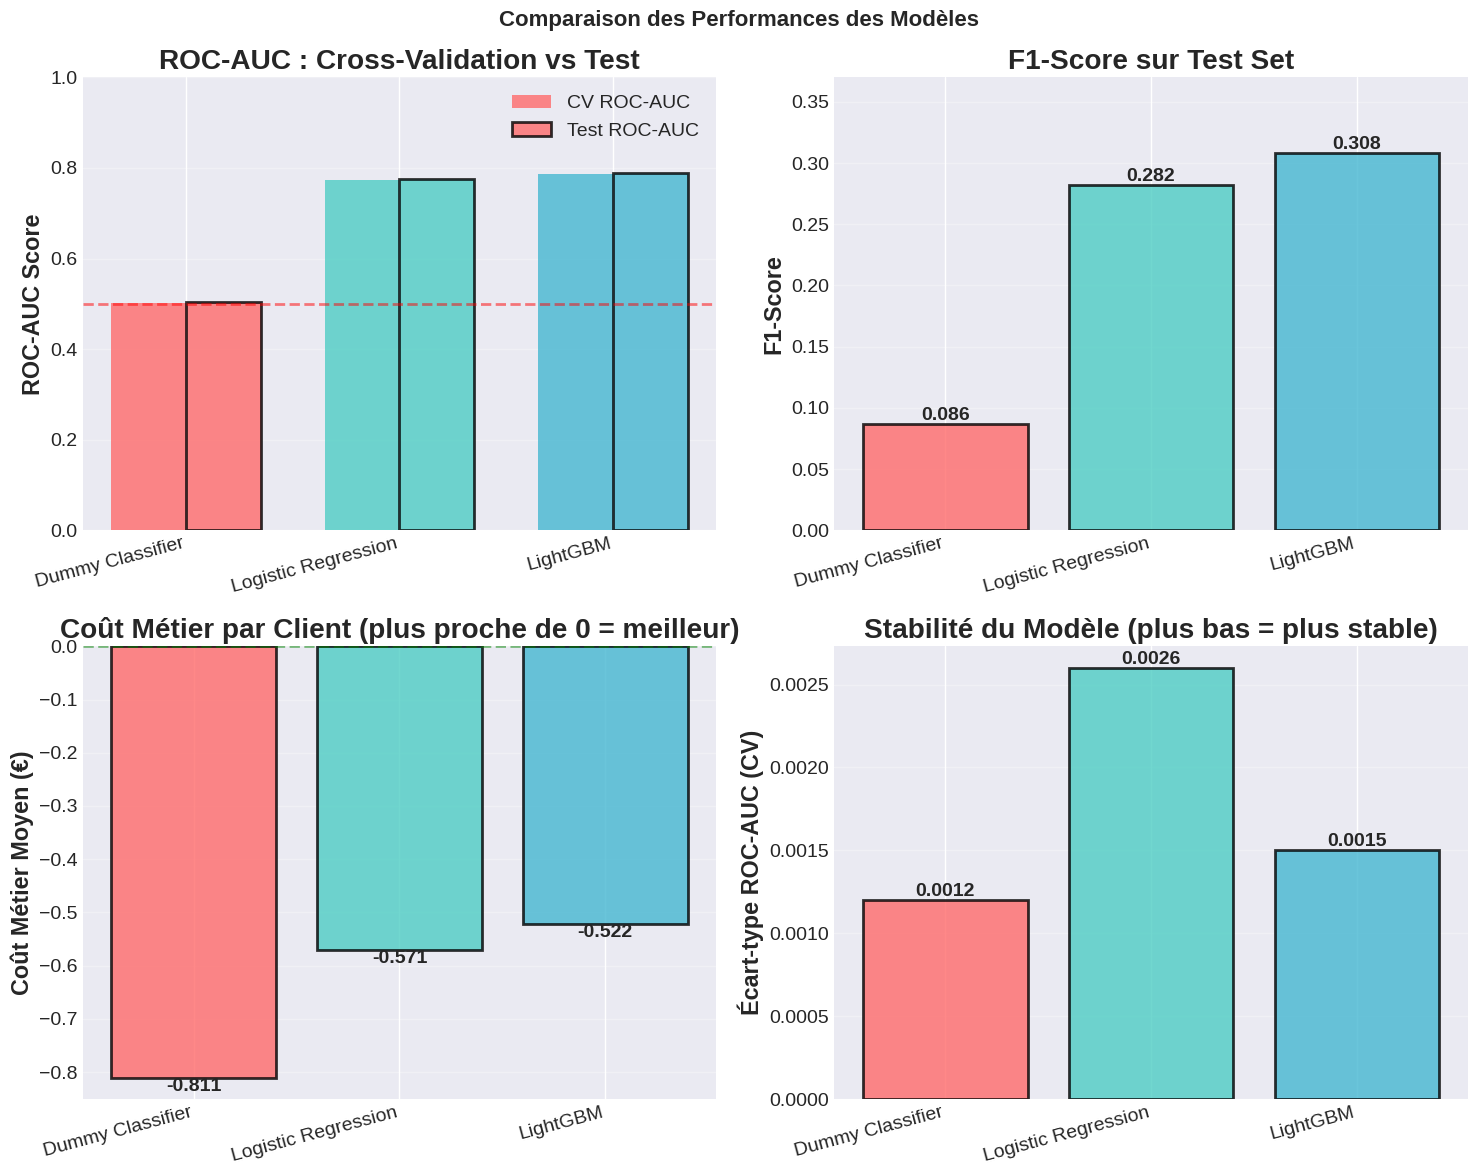


ANALYSE DES AM√âLIORATIONS PAR RAPPORT AU BASELINE

 Baseline (Dummy Classifier):
   - ROC-AUC: 0.5033
   - Co√ªt m√©tier: -0.8108 ‚Ç¨/client

 Am√©liorations:


Mod√®le Am√©lioration ROC-AUC (%) Am√©lioration Co√ªt (%)  \
0  Logistic Regression                  +54.14%               +29.61%   
1             LightGBM                  +56.81%               +35.59%   

  Gain ROC-AUC (points) R√©duction Co√ªt (‚Ç¨)  
0               +0.2725             0.2401  
1               +0.2859             0.2886


 RECOMMANDATION FINALE

‚úì Meilleur ROC-AUC: LightGBM (0.7892)
‚úì Meilleur Co√ªt M√©tier: LightGBM (-0.5222 ‚Ç¨/client)
‚úì Plus Stable: Dummy Classifier (std = 0.0012)

 RECOMMANDATION GLOBALE:
   ‚û§ LightGBM est le meilleur choix (meilleur sur AUC ET co√ªt m√©tier)

 COMPARAISON TERMIN√âE


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# STOCKAGE DES R√âSULTATS
# ============================================================================

# Dictionnaire pour stocker tous les r√©sultats
results = {
    'Dummy Classifier': {
        'cv_roc_auc_mean': 0.5018,
        'cv_roc_auc_std': 0.0012,
        'test_roc_auc': 0.5033,
        'test_f1': 0.0865,
        'test_business_cost': -0.8108,
        'y_pred_proba': None,  # √Ä remplir
        'y_pred': None  # √Ä remplir
    },
    'Logistic Regression': {
        'cv_roc_auc_mean': 0.7737,
        'cv_roc_auc_std': 0.0026,
        'test_roc_auc': 0.7758,
        'test_f1': 0.2820,
        'test_business_cost': -0.5707,
        'y_pred_proba': None,
        'y_pred': None
    },
    'LightGBM': {
        'cv_roc_auc_mean': 0.7857,
        'cv_roc_auc_std': 0.0015,
        'test_roc_auc': 0.7892,
        'test_f1': 0.3083,
        'test_business_cost': -0.5222,
        'y_pred_proba': None,
        'y_pred': None
    }
}

# ============================================================================
# 1. TABLEAU COMPARATIF
# ============================================================================

def create_comparison_table(results):
    """Cr√©e un DataFrame comparatif des mod√®les"""

    comparison_data = []
    for model_name, metrics in results.items():
        comparison_data.append({
            'Mod√®le': model_name,
            'CV ROC-AUC (mean)': metrics['cv_roc_auc_mean'],
            'CV ROC-AUC (std)': metrics['cv_roc_auc_std'],
            'Test ROC-AUC': metrics['test_roc_auc'],
            'Test F1-Score': metrics['test_f1'],
            'Co√ªt M√©tier': metrics['test_business_cost']
        })

    df_comparison = pd.DataFrame(comparison_data)

    # Trouve l'index de la ligne avec le meilleur co√ªt m√©tier (valeur la plus proche de 0)
    # Comme c'est n√©gatif, c'est la valeur maximale
    best_cost_index = df_comparison['Co√ªt M√©tier'].idxmax()

    # Styling pour Jupyter
    styled_table = df_comparison.style.set_properties(**{
        'background-color': '#f0f0f0',
        'color': 'black',
        'border-color': 'white'
    }).highlight_max(subset=['Test ROC-AUC', 'Test F1-Score'],
                     color='lightgreen')

    # Surligne explicitement la ligne avec le meilleur co√ªt m√©tier
    styled_table = styled_table.apply(
        lambda x: ['background-color: lightgreen' if x.name == best_cost_index else '' for i in x],
        axis=1,
        subset=['Co√ªt M√©tier'] # Applique le style uniquement √† la colonne Co√ªt M√©tier
    )


    return styled_table

print("="*80)
print("TABLEAU COMPARATIF DES MOD√àLES")
print("="*80)
display(create_comparison_table(results))

# ============================================================================
# 2. GRAPHIQUES DE COMPARAISON
# ============================================================================

def plot_model_comparison(results):
    """Cr√©e des graphiques de comparaison des mod√®les"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comparaison des Performances des Mod√®les', fontsize=16, fontweight='bold')

    models = list(results.keys())
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    # 1. ROC-AUC (CV et Test)
    ax1 = axes[0, 0]
    cv_aucs = [results[m]['cv_roc_auc_mean'] for m in models]
    test_aucs = [results[m]['test_roc_auc'] for m in models]

    x = np.arange(len(models))
    width = 0.35

    ax1.bar(x - width/2, cv_aucs, width, label='CV ROC-AUC', alpha=0.8, color=colors)
    ax1.bar(x + width/2, test_aucs, width, label='Test ROC-AUC', alpha=0.8,
            color=[c for c in colors], edgecolor='black', linewidth=2)

    ax1.set_ylabel('ROC-AUC Score', fontweight='bold')
    ax1.set_title('ROC-AUC : Cross-Validation vs Test', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=15, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim([0, 1])

    # Ligne de base √† 0.5 (al√©atoire)
    ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Random')

    # 2. F1-Score
    ax2 = axes[0, 1]
    f1_scores = [results[m]['test_f1'] for m in models]
    bars = ax2.bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax2.set_ylabel('F1-Score', fontweight='bold')
    ax2.set_title('F1-Score sur Test Set', fontweight='bold')
    ax2.set_xticklabels(models, rotation=15, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim([0, max(f1_scores) * 1.2])

    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    # 3. Co√ªt M√©tier (n√©gatif = co√ªt, donc plus proche de 0 = meilleur)
    ax3 = axes[1, 0]
    business_costs = [results[m]['test_business_cost'] for m in models]
    bars = ax3.bar(models, business_costs, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax3.set_ylabel('Co√ªt M√©tier Moyen (‚Ç¨)', fontweight='bold')
    ax3.set_title('Co√ªt M√©tier par Client (plus proche de 0 = meilleur)', fontweight='bold')
    ax3.set_xticklabels(models, rotation=15, ha='right')
    ax3.grid(axis='y', alpha=0.3)
    ax3.axhline(y=0, color='green', linestyle='--', linewidth=2, alpha=0.5)

    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top',
                fontweight='bold')

    # 4. Variance CV (stabilit√© du mod√®le)
    ax4 = axes[1, 1]
    cv_stds = [results[m]['cv_roc_auc_std'] for m in models]
    bars = ax4.bar(models, cv_stds, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax4.set_ylabel('√âcart-type ROC-AUC (CV)', fontweight='bold')
    ax4.set_title('Stabilit√© du Mod√®le (plus bas = plus stable)', fontweight='bold')
    ax4.set_xticklabels(models, rotation=15, ha='right')
    ax4.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("GRAPHIQUES DE COMPARAISON")
print("="*80)
plot_model_comparison(results)

# ============================================================================
# 3. COURBES ROC COMPAR√âES
# ============================================================================

def plot_roc_curves(results, y_test):
    """Compare les courbes ROC de tous les mod√®les"""

    plt.figure(figsize=(10, 8))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    for i, (model_name, metrics) in enumerate(results.items()):
        if metrics['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(y_test, metrics['y_pred_proba'])
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, color=colors[i], lw=3,
                    label=f'{model_name} (AUC = {roc_auc:.4f})')

    # Ligne de base (classificateur al√©atoire)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--',
             label='Al√©atoire (AUC = 0.5000)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12, fontweight='bold')
    plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12, fontweight='bold')
    plt.title('Courbes ROC - Comparaison des Mod√®les', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 4. MATRICES DE CONFUSION (si y_pred disponibles)
# ============================================================================

def plot_confusion_matrices(results, y_test):
    """Affiche les matrices de confusion de tous les mod√®les"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Matrices de Confusion', fontsize=16, fontweight='bold')

    for i, (model_name, metrics) in enumerate(results.items()):
        if metrics['y_pred'] is not None:
            cm = confusion_matrix(y_test, metrics['y_pred'])

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                       cbar_kws={'label': 'Nombre de pr√©dictions'})
            axes[i].set_title(model_name, fontweight='bold')
            axes[i].set_ylabel('Vraie Classe', fontweight='bold')
            axes[i].set_xlabel('Classe Pr√©dite', fontweight='bold')
            axes[i].set_xticklabels(['Pas D√©faut (0)', 'D√©faut (1)'])
            axes[i].set_yticklabels(['Pas D√©faut (0)', 'D√©faut (1)'])

            # Ajouter les taux
            tn, fp, fn, tp = cm.ravel()
            total = tn + fp + fn + tp
            axes[i].text(0.5, -0.15,
                        f'Accuracy: {(tn+tp)/total:.3f}\n'
                        f'FP: {fp} ({fp/total*100:.1f}%) | FN: {fn} ({fn/total*100:.1f}%)',
                        transform=axes[i].transAxes, ha='center',
                        fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. ANALYSE DES GAINS PAR RAPPORT AU BASELINE
# ============================================================================

def analyze_improvements(results):
    """Analyse les am√©liorations par rapport au Dummy Classifier"""

    baseline_model = 'Dummy Classifier'
    baseline_auc = results[baseline_model]['test_roc_auc']
    baseline_cost = results[baseline_model]['test_business_cost']

    print("\n" + "="*80)
    print("ANALYSE DES AM√âLIORATIONS PAR RAPPORT AU BASELINE")
    print("="*80)

    improvements = []
    for model_name, metrics in results.items():
        if model_name != baseline_model:
            auc_improvement = ((metrics['test_roc_auc'] - baseline_auc) / baseline_auc) * 100
            cost_improvement = ((metrics['test_business_cost'] - baseline_cost) / abs(baseline_cost)) * 100

            improvements.append({
                'Mod√®le': model_name,
                'Am√©lioration ROC-AUC (%)': f"+{auc_improvement:.2f}%",
                'Am√©lioration Co√ªt (%)': f"+{cost_improvement:.2f}%",
                'Gain ROC-AUC (points)': f"+{(metrics['test_roc_auc'] - baseline_auc):.4f}",
                'R√©duction Co√ªt (‚Ç¨)': f"{(metrics['test_business_cost'] - baseline_cost):.4f}"
            })

    df_improvements = pd.DataFrame(improvements)

    print(f"\n Baseline (Dummy Classifier):")
    print(f"   - ROC-AUC: {baseline_auc:.4f}")
    print(f"   - Co√ªt m√©tier: {baseline_cost:.4f} ‚Ç¨/client")
    print(f"\n Am√©liorations:")
    display(df_improvements)

    return df_improvements

analyze_improvements(results)

# ============================================================================
# 6. RECOMMANDATION FINALE
# ============================================================================

def recommend_best_model(results):
    """Recommande le meilleur mod√®le selon plusieurs crit√®res"""

    print("\n" + "="*80)
    print(" RECOMMANDATION FINALE")
    print("="*80)

    # Meilleur ROC-AUC
    best_auc_model = max(results.items(), key=lambda x: x[1]['test_roc_auc'])
    print(f"\n‚úì Meilleur ROC-AUC: {best_auc_model[0]} ({best_auc_model[1]['test_roc_auc']:.4f})")

    # Meilleur co√ªt m√©tier
    best_cost_model = max(results.items(), key=lambda x: x[1]['test_business_cost'])
    print(f"‚úì Meilleur Co√ªt M√©tier: {best_cost_model[0]} ({best_cost_model[1]['test_business_cost']:.4f} ‚Ç¨/client)")

    # Plus stable (CV variance)
    most_stable_model = min(results.items(), key=lambda x: x[1]['cv_roc_auc_std'])
    print(f"‚úì Plus Stable: {most_stable_model[0]} (std = {most_stable_model[1]['cv_roc_auc_std']:.4f})")

    # Recommandation globale
    print(f"\n RECOMMANDATION GLOBALE:")
    if best_auc_model[0] == best_cost_model[0]:
        print(f"   ‚û§ {best_auc_model[0]} est le meilleur choix (meilleur sur AUC ET co√ªt m√©tier)")
    else:
        print(f"   ‚û§ {best_cost_model[0]} pour optimiser le co√ªt m√©tier")
        print(f"   ‚û§ {best_auc_model[0]} pour maximiser la performance pr√©dictive (ROC-AUC)")

recommend_best_model(results)

print("\n" + "="*80)
print(" COMPARAISON TERMIN√âE")
print("="*80)

In [50]:
# Trouve le seuil optimal pour minimiser le co√ªt m√©tier
thresholds = np.arange(0.1, 0.9, 0.01)
costs = []

for threshold in thresholds:
    # Utilise la variable y_pred_proba qui contient les pr√©dictions du mod√®le LightGBM
    cost = business_cost_score(y_test, y_pred_proba, threshold=threshold)
    costs.append(cost)

optimal_threshold = thresholds[np.argmax(costs)]
print(f"Seuil optimal : {optimal_threshold:.2f}")
print(f"Co√ªt optimal : {max(costs):.4f}")

Seuil optimal : 0.50
Co√ªt optimal : -0.4837


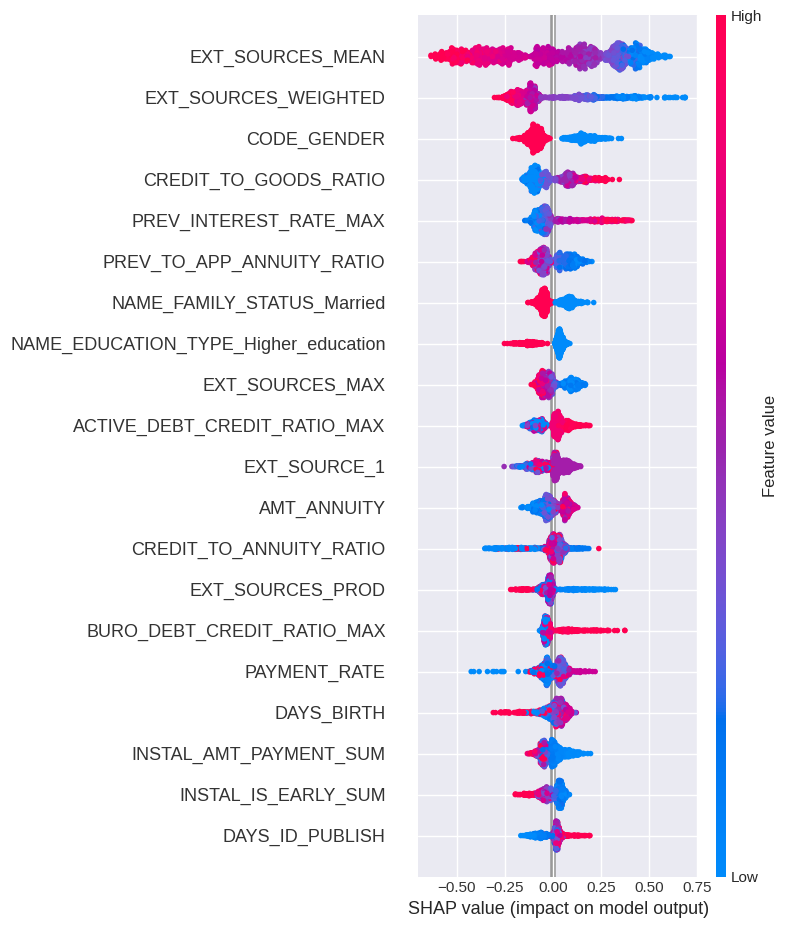

In [51]:
import shap

# Feature importance native LightGBM
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_clf.feature_importances_
}).sort_values('importance', ascending=False).head(20)

# SHAP values
explainer = shap.TreeExplainer(lgbm_clf)
shap_values = explainer.shap_values(X_test[:1000])  # Sur √©chantillon
shap.summary_plot(shap_values, X_test[:1000])

In [52]:
# Matrice de confusion avec seuil optimal
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_optimal)

# Analyse des faux n√©gatifs (plus co√ªteux)
false_negatives = X_test[(y_test == 1) & (y_pred_optimal == 0)]
print(f"Analyse des {len(false_negatives)} faux n√©gatifs...")

Analyse des 1656 faux n√©gatifs...


In [53]:
# ============================================================================
# IDENTIFICATION DES FAUX N√âGATIFS
# ============================================================================

optimal_threshold = 0.50  # Ton seuil optimal
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Indices des diff√©rentes cat√©gories
true_positives_idx = (y_test == 1) & (y_pred_optimal == 1)
false_negatives_idx = (y_test == 1) & (y_pred_optimal == 0)  # Les plus co√ªteux !
true_negatives_idx = (y_test == 0) & (y_pred_optimal == 0)
false_positives_idx = (y_test == 0) & (y_pred_optimal == 1)

print("=" * 80)
print("R√âPARTITION DES PR√âDICTIONS")
print("=" * 80)
print(f"‚úì Vrais Positifs (TP)  : {true_positives_idx.sum():6d} - D√©fauts correctement d√©tect√©s")
print(f"Faux N√©gatifs (FN)  : {false_negatives_idx.sum():6d} - D√©fauts NON d√©tect√©s (CO√õTEUX !)")
print(f"‚úì Vrais N√©gatifs (TN)  : {true_negatives_idx.sum():6d} - Bons clients correctement accept√©s")
print(f" Faux Positifs (FP)   : {false_positives_idx.sum():6d} - Bons clients refus√©s")

# Co√ªt total
fn_cost = false_negatives_idx.sum() * 10  # Co√ªt unitaire = 10
fp_cost = false_positives_idx.sum() * 1   # Co√ªt unitaire = 1
total_cost = fn_cost + fp_cost

print(f"\n CO√õT TOTAL:")
print(f"  ‚Ä¢ Co√ªt FN (10‚Ç¨/client) : {fn_cost:,}‚Ç¨")
print(f"  ‚Ä¢ Co√ªt FP (1‚Ç¨/client)  : {fp_cost:,}‚Ç¨")
print(f"  ‚Ä¢ CO√õT TOTAL           : {total_cost:,}‚Ç¨")

R√âPARTITION DES PR√âDICTIONS
‚úì Vrais Positifs (TP)  :   3309 - D√©fauts correctement d√©tect√©s
Faux N√©gatifs (FN)  :   1656 - D√©fauts NON d√©tect√©s (CO√õTEUX !)
‚úì Vrais N√©gatifs (TN)  :  43346 - Bons clients correctement accept√©s
 Faux Positifs (FP)   :  13191 - Bons clients refus√©s

 CO√õT TOTAL:
  ‚Ä¢ Co√ªt FN (10‚Ç¨/client) : 16,560‚Ç¨
  ‚Ä¢ Co√ªt FP (1‚Ç¨/client)  : 13,191‚Ç¨
  ‚Ä¢ CO√õT TOTAL           : 29,751‚Ç¨


In [54]:
# ============================================================================
# COMPARAISON PROFILS : FAUX N√âGATIFS vs VRAIS POSITIFS
# ============================================================================

print("\n" + "=" * 80)
print("COMPARAISON DE PROFILS : FN vs TP")
print("=" * 80)

# Extraction des donn√©es
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

fn_data = X_test_reset[false_negatives_idx.values]
tp_data = X_test_reset[true_positives_idx.values]

# Features les plus importantes √† comparer
top_features = [
    'EXT_SOURCES_MEAN', 'EXT_SOURCES_WEIGHTED', 'CODE_GENDER',
    'CREDIT_TO_GOODS_RATIO', 'PAYMENT_RATE', 'DAYS_BIRTH',
    'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY'
]

# Tableau comparatif
comparison = pd.DataFrame({
    'Feature': top_features,
    'FN (non d√©tect√©s)': [fn_data[f].mean() if f in fn_data.columns else np.nan for f in top_features],
    'TP (d√©tect√©s)': [tp_data[f].mean() if f in tp_data.columns else np.nan for f in top_features],
})

comparison['Diff√©rence (%)'] = ((comparison['FN (non d√©tect√©s)'] - comparison['TP (d√©tect√©s)']) /
                                 comparison['TP (d√©tect√©s)'].abs() * 100)

print("\n MOYENNES DES FEATURES CL√âS:")
print(comparison.to_string(index=False))



COMPARAISON DE PROFILS : FN vs TP

 MOYENNES DES FEATURES CL√âS:
              Feature  FN (non d√©tect√©s)  TP (d√©tect√©s)  Diff√©rence (%)
     EXT_SOURCES_MEAN           0.522240       0.384921       35.674349
 EXT_SOURCES_WEIGHTED           4.720659       3.400849       38.808247
          CODE_GENDER           0.662440       0.525536       26.050183
CREDIT_TO_GOODS_RATIO           1.121383       1.169275       -4.095858
         PAYMENT_RATE           0.051523       0.055971       -7.947618
           DAYS_BIRTH      -16499.620773  -14228.288909      -15.963493
           AMT_CREDIT      617248.584239  529825.947416       16.500256
     AMT_INCOME_TOTAL      168975.309783  158776.432004        6.423420
          AMT_ANNUITY       26908.038043   26254.181777        2.490484



 STATISTIQUES DES PROBABILIT√âS PR√âDITES:
  ‚Ä¢ FN moyenne : 0.320 (√©cart-type: 0.119)
  ‚Ä¢ TP moyenne : 0.718 (√©cart-type: 0.116)
  ‚Ä¢ Les FN ont des probabilit√©s proches du seuil ‚Üí difficiles √† d√©tecter


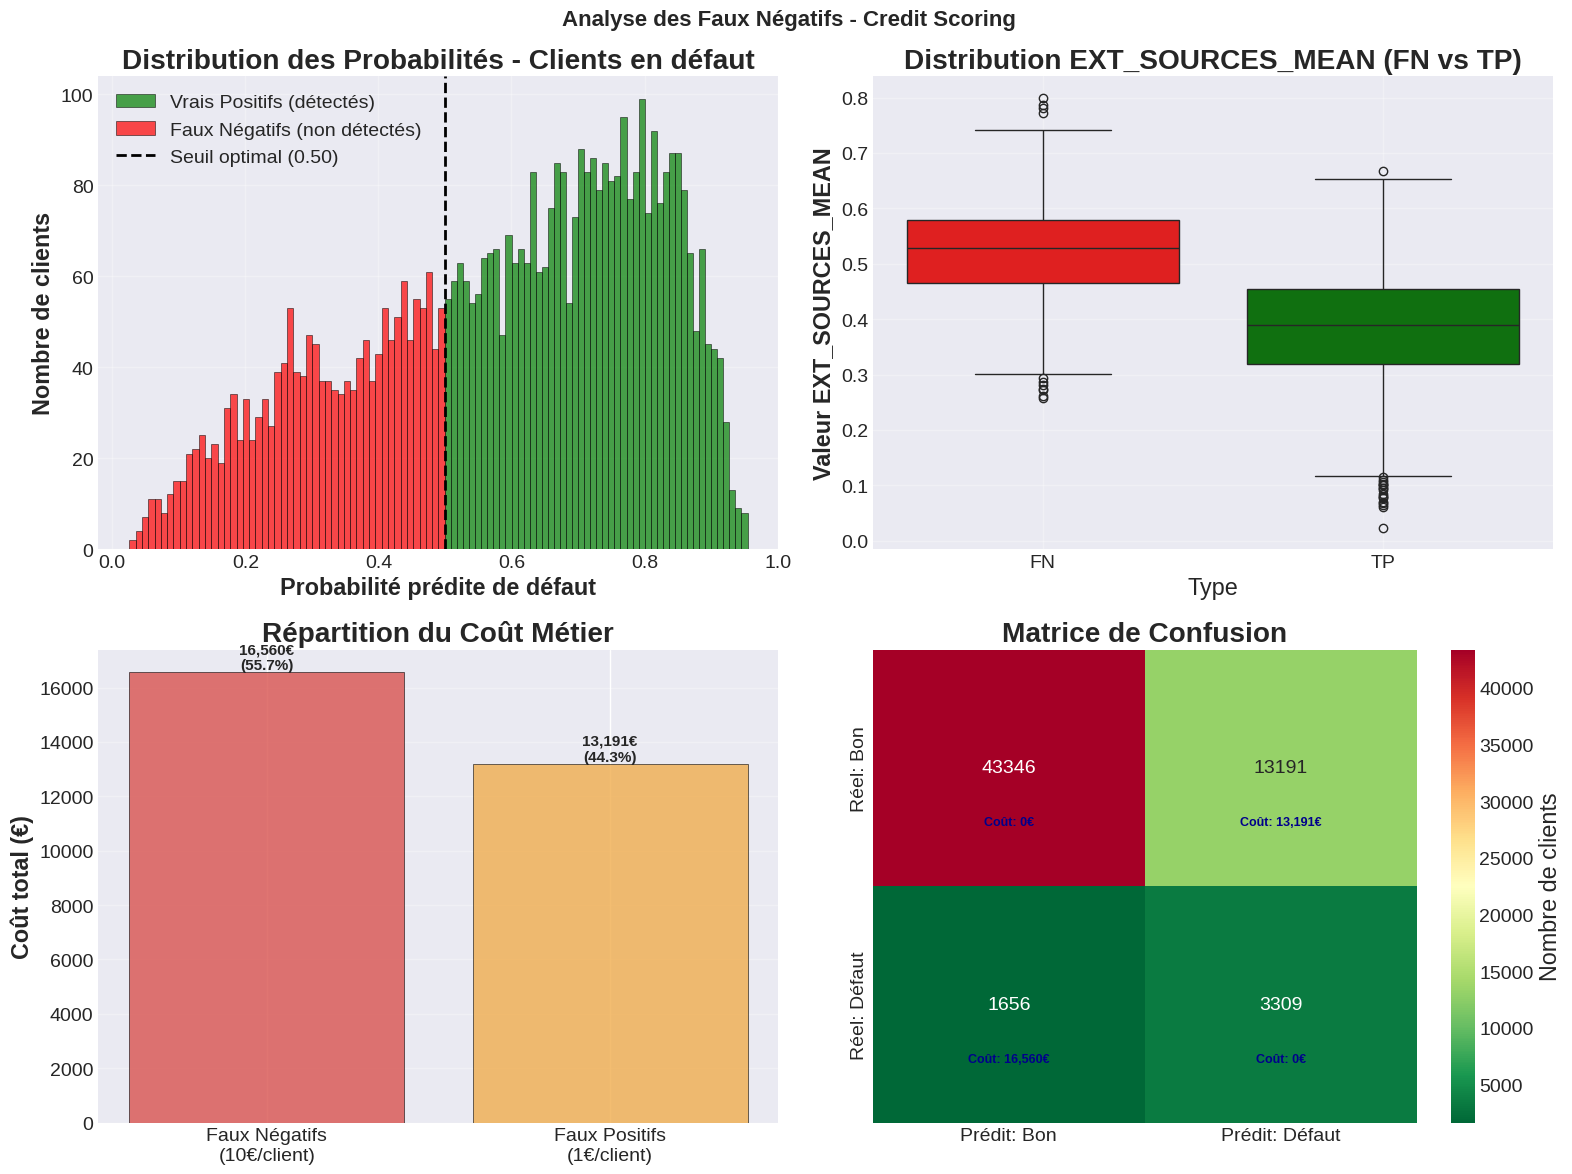

In [55]:
# ============================================================================
# DISTRIBUTION DES PROBABILIT√âS PR√âDITES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse des Faux N√©gatifs - Credit Scoring', fontsize=16, fontweight='bold')

# --- GRAPHIQUE 1 : Distribution des probabilit√©s ---
ax1 = axes[0, 0]

# Probabilit√©s pour les d√©fauts (y=1)
fn_probs = y_pred_proba[false_negatives_idx.values]
tp_probs = y_pred_proba[true_positives_idx.values]

ax1.hist(tp_probs, bins=50, alpha=0.7, label='Vrais Positifs (d√©tect√©s)', color='green', edgecolor='black')
ax1.hist(fn_probs, bins=50, alpha=0.7, label='Faux N√©gatifs (non d√©tect√©s)', color='red', edgecolor='black')
ax1.axvline(optimal_threshold, color='black', linestyle='--', linewidth=2, label=f'Seuil optimal ({optimal_threshold:.2f})') # Added formatting
ax1.set_xlabel('Probabilit√© pr√©dite de d√©faut', fontweight='bold')
ax1.set_ylabel('Nombre de clients', fontweight='bold')
ax1.set_title('Distribution des Probabilit√©s - Clients en d√©faut', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

print(f"\n STATISTIQUES DES PROBABILIT√âS PR√âDITES:")
print(f"  ‚Ä¢ FN moyenne : {fn_probs.mean():.3f} (√©cart-type: {fn_probs.std():.3f})")
print(f"  ‚Ä¢ TP moyenne : {tp_probs.mean():.3f} (√©cart-type: {tp_probs.std():.3f})")
print(f"  ‚Ä¢ Les FN ont des probabilit√©s proches du seuil ‚Üí difficiles √† d√©tecter")

# --- GRAPHIQUE 2 : Box plots des features cl√©s ---
ax2 = axes[0, 1]

# Pr√©parer les donn√©es pour le box plot
if 'EXT_SOURCES_MEAN' in fn_data.columns and 'EXT_SOURCES_MEAN' in tp_data.columns:
    # Combine the data for the selected feature
    combined_data = pd.concat([
        fn_data[['EXT_SOURCES_MEAN']].assign(Type='FN'),
        tp_data[['EXT_SOURCES_MEAN']].assign(Type='TP')
    ])

    sns.boxplot(data=combined_data, x='Type', y='EXT_SOURCES_MEAN', ax=ax2, palette=['red', 'green'])
    ax2.set_title('Distribution EXT_SOURCES_MEAN (FN vs TP)', fontweight='bold') # Added (FN vs TP)
    ax2.set_ylabel('Valeur EXT_SOURCES_MEAN', fontweight='bold') # More specific label
    ax2.grid(alpha=0.3)

# --- GRAPHIQUE 3 : Co√ªt par cat√©gorie ---
ax3 = axes[1, 0]

categories = ['Faux N√©gatifs\n(10‚Ç¨/client)', 'Faux Positifs\n(1‚Ç¨/client)']
costs = [fn_cost, fp_cost]
colors = ['#d9534f', '#f0ad4e']

bars = ax3.bar(categories, costs, color=colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('Co√ªt total (‚Ç¨)', fontweight='bold')
ax3.set_title('R√©partition du Co√ªt M√©tier', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Annotations
for bar, cost in zip(bars, costs):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{cost:,}‚Ç¨\n({cost/total_cost*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# --- GRAPHIQUE 4 : Matrice de confusion ---
ax4 = axes[1, 1]

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', ax=ax4,
            xticklabels=['Pr√©dit: Bon', 'Pr√©dit: D√©faut'],
            yticklabels=['R√©el: Bon', 'R√©el: D√©faut'],
            cbar_kws={'label': 'Nombre de clients'})

ax4.set_title('Matrice de Confusion', fontweight='bold')

# Ajouter les co√ªts
for i in range(2):
    for j in range(2):
        if i == 1 and j == 0:  # FN
            cost_text = f"\nCo√ªt: {cm[i,j] * 10:,}‚Ç¨"
        elif i == 0 and j == 1:  # FP
            cost_text = f"\nCo√ªt: {cm[i,j] * 1:,}‚Ç¨"
        else:
            cost_text = "\nCo√ªt: 0‚Ç¨"

        ax4.text(j + 0.5, i + 0.7, cost_text,
                ha='center', va='center', fontsize=9, color='darkblue', fontweight='bold')

plt.tight_layout()
plt.savefig('false_negatives_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
# ============================================================================
# PROFIL-TYPE DU FAUX N√âGATIF
# ============================================================================

print("\n" + "=" * 80)
print("PROFIL-TYPE DU FAUX N√âGATIF (Client d√©faillant non d√©tect√©)")
print("=" * 80)

print("\n CARACT√âRISTIQUES COMMUNES:")

# Calculer les percentiles
if 'EXT_SOURCES_MEAN' in fn_data.columns:
    ext_source_percentile = (fn_data['EXT_SOURCES_MEAN'].mean() /
                             X_test_reset['EXT_SOURCES_MEAN'].mean() * 100)
    print(f"  ‚Ä¢ Score externe : {fn_data['EXT_SOURCES_MEAN'].mean():.3f} "
          f"({ext_source_percentile:.0f}% de la moyenne)")

if 'AMT_CREDIT' in fn_data.columns:
    print(f"  ‚Ä¢ Montant cr√©dit moyen : {fn_data['AMT_CREDIT'].mean():,.0f}‚Ç¨")

if 'AMT_INCOME_TOTAL' in fn_data.columns:
    print(f"  ‚Ä¢ Revenu moyen : {fn_data['AMT_INCOME_TOTAL'].mean():,.0f}‚Ç¨")

if 'DAYS_BIRTH' in fn_data.columns:
    age_years = -fn_data['DAYS_BIRTH'].mean() / 365
    print(f"  ‚Ä¢ √Çge moyen : {age_years:.1f} ans")

print(f"\n INSIGHT CL√â:")
print(f"  Les FN ont des probabilit√©s moyennes de {fn_probs.mean():.3f}, juste en dessous")
print(f"  du seuil de {optimal_threshold}. Ce sont des cas limites difficiles √† classifier.")


PROFIL-TYPE DU FAUX N√âGATIF (Client d√©faillant non d√©tect√©)

 CARACT√âRISTIQUES COMMUNES:
  ‚Ä¢ Score externe : 0.522 (102% de la moyenne)
  ‚Ä¢ Montant cr√©dit moyen : 617,249‚Ç¨
  ‚Ä¢ Revenu moyen : 168,975‚Ç¨
  ‚Ä¢ √Çge moyen : 45.2 ans

 INSIGHT CL√â:
  Les FN ont des probabilit√©s moyennes de 0.320, juste en dessous
  du seuil de 0.5. Ce sont des cas limites difficiles √† classifier.


In [58]:
import pickle
import pandas as pd
from lightgbm import LGBMClassifier

# ============================================================================
# SAUVEGARDE DU MOD√àLE ET DES OBJETS N√âCESSAIRES
# ============================================================================

print(" Sauvegarde du mod√®le et des composants...")

# 1. Sauvegarde le mod√®le LightGBM
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm_clf, f)
print("‚úì Mod√®le LightGBM sauvegard√© : lgbm_model.pkl")

# 2. Sauvegarde l'imputer (pour g√©rer les NaN)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)

with open('imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)
print("‚úì Imputer sauvegard√© : imputer.pkl")

# 3. Sauvegarde la liste des features attendues
feature_names = list(X_train.columns)
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print("‚úì Noms des features sauvegard√©s : feature_names.pkl")

# 4. Sauvegarde un exemple de donn√©es pour tester l'API
example_data = X_test.iloc[0:5].to_dict('records')
with open('example_data.pkl', 'wb') as f:
    pickle.dump(example_data, f)
print("‚úì Donn√©es d'exemple sauvegard√©es : example_data.pkl")

print("\n" + "=" * 60)
print(" TOUT EST SAUVEGARD√â !")
print("=" * 60)
print(f" Nombre de features : {len(feature_names)}")
print(f" Performance du mod√®le : ROC-AUC = {roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1]):.4f}")

 Sauvegarde du mod√®le et des composants...
‚úì Mod√®le LightGBM sauvegard√© : lgbm_model.pkl
‚úì Imputer sauvegard√© : imputer.pkl
‚úì Noms des features sauvegard√©s : feature_names.pkl
‚úì Donn√©es d'exemple sauvegard√©es : example_data.pkl

 TOUT EST SAUVEGARD√â !
 Nombre de features : 777
 Performance du mod√®le : ROC-AUC = 0.7892


In [59]:
# T√âL√âCHARGEMENT DES RUNS MLFLOW POUR L'UI
import shutil
from google.colab import files
import os

# V√©rifie que mlruns existe
if os.path.exists('./mlruns'):
    print(" Dossier mlruns trouv√© !")

    # Liste les runs
    for root, dirs, files_list in os.walk('./mlruns'):
        if 'meta.yaml' in files_list:
            print(f"   Run trouv√© : {root}")

    # Compresse tout
    shutil.make_archive('mlruns', 'zip', './mlruns')
    print("\n Archive mlruns.zip cr√©√©e !")

    # T√©l√©charge
    files.download('mlruns.zip')
    print(" T√©l√©chargement lanc√©...")
else:
    print(" Dossier mlruns introuvable !")

 Dossier mlruns trouv√© !
   Run trouv√© : ./mlruns/208818114892204756
   Run trouv√© : ./mlruns/208818114892204756/62ef289b259948b99c439b17f83fb7b4
   Run trouv√© : ./mlruns/208818114892204756/62ef289b259948b99c439b17f83fb7b4/outputs/m-13e65c3fa7764fcf85ecee063e3a3362
   Run trouv√© : ./mlruns/208818114892204756/models/m-13e65c3fa7764fcf85ecee063e3a3362
   Run trouv√© : ./mlruns/208818114892204756/models/m-e1d67a1c56414efe88cd21069d475a71
   Run trouv√© : ./mlruns/208818114892204756/models/m-fc0a9c4a6ea04b00b68efd77e9fecd33
   Run trouv√© : ./mlruns/208818114892204756/75b08051e0a943429aa75e0af8c7a2c6
   Run trouv√© : ./mlruns/208818114892204756/75b08051e0a943429aa75e0af8c7a2c6/outputs/m-e1d67a1c56414efe88cd21069d475a71
   Run trouv√© : ./mlruns/208818114892204756/1870f7cb7b7f4aa1993df0bc8d9f1d2a
   Run trouv√© : ./mlruns/208818114892204756/1870f7cb7b7f4aa1993df0bc8d9f1d2a/outputs/m-fc0a9c4a6ea04b00b68efd77e9fecd33
   Run trouv√© : ./mlruns/0

 Archive mlruns.zip cr√©√©e !


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 T√©l√©chargement lanc√©...
